In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from tqdm.auto import tqdm
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
train=pd.read_csv("train.csv",encoding="big5")
test=pd.read_csv("test.csv",encoding="big5")

C:\Users\a2279\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (17,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(train.shape)
print(test.shape)

(100000, 132)
(150000, 131)


In [4]:
train.head()

,CUS_ID,GENDER,AGE,CHARGE_CITY_CD,CONTACT_CITY_CD,EDUCATION_CD,MARRIAGE_CD,LAST_A_CCONTACT_DT,L1YR_A_ISSUE_CNT,LAST_A_ISSUE_DT,...,L1YR_GROSS_PRE_AMT,CUST_9_SEGMENTS_CD,FINANCETOOLS_A,FINANCETOOLS_B,FINANCETOOLS_C,FINANCETOOLS_D,FINANCETOOLS_E,FINANCETOOLS_F,FINANCETOOLS_G,Y1
0,3418,M,低,A1,A1,NaN,NaN,Y,0,N,...,0.000174,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,4302,M,低,A1,A1,NaN,NaN,Y,0,N,...,0.008724,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,5545,M,低,A1,A1,1.0,0.0,Y,1,Y,...,0.005359,A,Y,N,N,N,N,N,N,N
3,7207,M,低,A1,A1,NaN,0.0,Y,0,N,...,0.000000,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,7213,M,低,A1,A1,1.0,0.0,N,0,N,...,0.000603,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


In [5]:
test.head()

,CUS_ID,GENDER,AGE,CHARGE_CITY_CD,CONTACT_CITY_CD,EDUCATION_CD,MARRIAGE_CD,LAST_A_CCONTACT_DT,L1YR_A_ISSUE_CNT,LAST_A_ISSUE_DT,...,IF_ADD_INSD_IND,L1YR_GROSS_PRE_AMT,CUST_9_SEGMENTS_CD,FINANCETOOLS_A,FINANCETOOLS_B,FINANCETOOLS_C,FINANCETOOLS_D,FINANCETOOLS_E,FINANCETOOLS_F,FINANCETOOLS_G
0,1193,M,低,A1,A1,2.0,0.0,Y,4,Y,...,Y,0.000151,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1727,M,低,A1,A1,NaN,0.0,N,0,N,...,N,0.000000,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3293,M,低,A1,A1,1.0,0.0,N,0,N,...,N,0.000090,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4328,M,低,A1,A1,NaN,0.0,N,0,N,...,N,0.000000,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5555,M,低,A1,A1,1.0,0.0,Y,0,Y,...,N,0.000179,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
train_x=train.drop(["Y1"],axis=1)

In [4]:
train_y=pd.DataFrame(train["Y1"])

In [10]:
train_y.to_csv("train_y.csv",encoding="big5",index=False)

In [5]:
train_test=train_x.append(test)

In [6]:
train_test.shape

(250000, 131)

In [13]:
train_test.to_csv("train_test.csv",encoding="big5",index=False)

In [65]:
train_test=pd.read_csv("train_test.csv",encoding="big5")

In [46]:
train_test.shape

(250000, 131)

## 分為連續型變數,有序型類別變數,無序型類別變數

In [66]:
int_features = []
float_features = []
object_features = []

for dtype, feature in zip(train_test.dtypes,train_test.columns):
    if dtype == 'float64':
        float_features.append(feature)
    elif dtype == 'int64':
        int_features.append(feature)
    else:
        object_features.append(feature)
print(f'{len(int_features)} Integer Features : {int_features}\n')
print(f'{len(float_features)} Float Features : {float_features}\n')
print(f'{len(object_features)} Object Features : {object_features}')

12 Integer Features : ['L1YR_A_ISSUE_CNT', 'L1YR_B_ISSUE_CNT', 'CHANNEL_A_POL_CNT', 'CHANNEL_B_POL_CNT', 'APC_CNT', 'INSD_CNT', 'AG_CNT', 'AG_NOW_CNT', 'CLC_CUR_NUM', 'L1YR_C_CNT', 'IM_CNT', 'TOOL_VISIT_1YEAR_CNT']

29 Float Features : ['EDUCATION_CD', 'MARRIAGE_CD', 'OCCUPATION_CLASS_CD', 'APC_1ST_YEARDIF', 'LEVEL', 'RFM_M_LEVEL', 'ANNUAL_PREMIUM_AMT', 'ANNUAL_INCOME_AMT', 'BANK_NUMBER_CNT', 'INSD_LAST_YEARDIF_CNT', 'BMI', 'TERMINATION_RATE', 'DIEBENEFIT_AMT', 'DIEACCIDENT_AMT', 'POLICY_VALUE_AMT', 'ANNUITY_AMT', 'EXPIRATION_AMT', 'ACCIDENT_HOSPITAL_REC_AMT', 'DISEASES_HOSPITAL_REC_AMT', 'OUTPATIENT_SURGERY_AMT', 'INPATIENT_SURGERY_AMT', 'PAY_LIMIT_MED_MISC_AMT', 'FIRST_CANCER_AMT', 'ILL_ACCELERATION_AMT', 'ILL_ADDITIONAL_AMT', 'LONG_TERM_CARE_AMT', 'MONTHLY_CARE_AMT', 'LIFE_INSD_CNT', 'L1YR_GROSS_PRE_AMT']

89 Object Features : ['GENDER', 'AGE', 'CHARGE_CITY_CD', 'CONTACT_CITY_CD', 'LAST_A_CCONTACT_DT', 'LAST_A_ISSUE_DT', 'LAST_B_ISSUE_DT', 'APC_1ST_AGE', 'INSD_1ST_AGE', 'IF_2ND_GEN_

In [48]:
train_test=train_test.drop(["CUS_ID"],axis=1)

In [67]:
train_test["EDUCATION_CD"]=train_test["EDUCATION_CD"].astype("object")
train_test["MARRIAGE_CD"]=train_test["MARRIAGE_CD"].astype("object")
train_test["OCCUPATION_CLASS_CD"]=train_test["OCCUPATION_CLASS_CD"].astype("object")
train_test["LEVEL"]=train_test["LEVEL"].astype("object")
train_test["RFM_M_LEVEL"]=train_test["RFM_M_LEVEL"].astype("object")

In [68]:
int_features = []
float_features = []
object_features = []

for dtype, feature in zip(train_test.dtypes,train_test.columns):
    if dtype == 'float64':
        float_features.append(feature)
    elif dtype == 'int64':
        int_features.append(feature)
    else:
        object_features.append(feature)
print(f'{len(int_features)} Integer Features : {int_features}\n')
print(f'{len(float_features)} Float Features : {float_features}\n')
print(f'{len(object_features)} Object Features : {object_features}')

12 Integer Features : ['L1YR_A_ISSUE_CNT', 'L1YR_B_ISSUE_CNT', 'CHANNEL_A_POL_CNT', 'CHANNEL_B_POL_CNT', 'APC_CNT', 'INSD_CNT', 'AG_CNT', 'AG_NOW_CNT', 'CLC_CUR_NUM', 'L1YR_C_CNT', 'IM_CNT', 'TOOL_VISIT_1YEAR_CNT']

24 Float Features : ['APC_1ST_YEARDIF', 'ANNUAL_PREMIUM_AMT', 'ANNUAL_INCOME_AMT', 'BANK_NUMBER_CNT', 'INSD_LAST_YEARDIF_CNT', 'BMI', 'TERMINATION_RATE', 'DIEBENEFIT_AMT', 'DIEACCIDENT_AMT', 'POLICY_VALUE_AMT', 'ANNUITY_AMT', 'EXPIRATION_AMT', 'ACCIDENT_HOSPITAL_REC_AMT', 'DISEASES_HOSPITAL_REC_AMT', 'OUTPATIENT_SURGERY_AMT', 'INPATIENT_SURGERY_AMT', 'PAY_LIMIT_MED_MISC_AMT', 'FIRST_CANCER_AMT', 'ILL_ACCELERATION_AMT', 'ILL_ADDITIONAL_AMT', 'LONG_TERM_CARE_AMT', 'MONTHLY_CARE_AMT', 'LIFE_INSD_CNT', 'L1YR_GROSS_PRE_AMT']

94 Object Features : ['GENDER', 'AGE', 'CHARGE_CITY_CD', 'CONTACT_CITY_CD', 'EDUCATION_CD', 'MARRIAGE_CD', 'LAST_A_CCONTACT_DT', 'LAST_A_ISSUE_DT', 'LAST_B_ISSUE_DT', 'OCCUPATION_CLASS_CD', 'APC_1ST_AGE', 'INSD_1ST_AGE', 'IF_2ND_GEN_IND', 'RFM_R', 'REBUY_TI

## 缺失值處理

In [32]:
pd.DataFrame([[i,train_test[i].isnull().sum()/len(train_test)] for i in int_features],columns=["variable","prop"])

,variable,prop
0,L1YR_A_ISSUE_CNT,0.0
1,L1YR_B_ISSUE_CNT,0.0
2,CHANNEL_A_POL_CNT,0.0
3,CHANNEL_B_POL_CNT,0.0
4,APC_CNT,0.0
5,INSD_CNT,0.0
6,AG_CNT,0.0
7,AG_NOW_CNT,0.0
8,CLC_CUR_NUM,0.0
9,IM_CNT,0.0


In [11]:
float_null=pd.DataFrame([[i,train_test[i].isnull().sum()/len(train_test)] for i in float_features],columns=["variable","prop"])

In [12]:
object_null=pd.DataFrame([[i,train_test[i].isnull().sum()/len(train_test)] for i in object_features if (train_test[i].isnull().sum())!=0],columns=["variable","prop"])

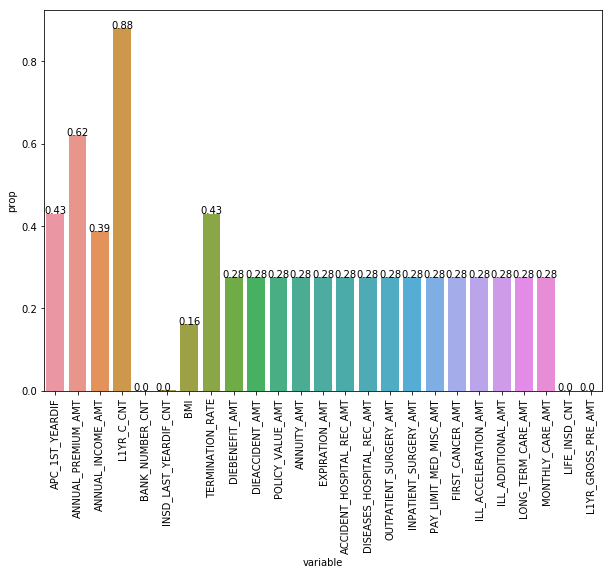

In [56]:
plt.figure(figsize=(10,7))
sns.barplot(x="variable",y="prop",data=float_null)
plt.xticks(rotation=90)
for i in range(len(float_null)):
    plt.text(i-0.5,float_null["prop"][i],round(float_null["prop"][i],2))

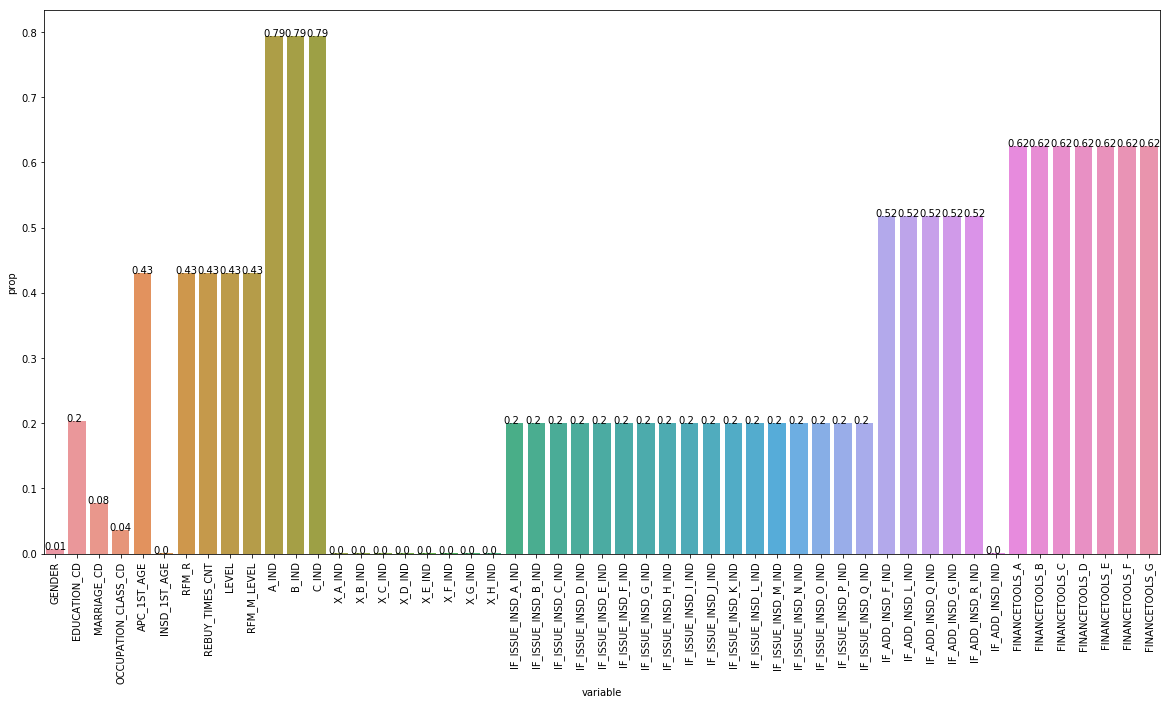

In [57]:
plt.figure(figsize=(20,10))
sns.barplot(x="variable",y="prop",data=object_null)
plt.xticks(rotation=90)
for i in range(len(object_null)):
    plt.text(i-0.5,object_null["prop"][i],round(object_null["prop"][i],2))

In [13]:
train_test["L1YR_C_CNT"].unique()

array([nan,  1.,  6., 12.,  2., 14.,  5., 10.,  3.,  4.,  9., 13.,  8.,
       11.,  7., 15., 17., 16., 30., 23., 22., 35., 18., 29., 25., 19.,
       24., 37., 27., 41., 21., 31., 47., 20.])

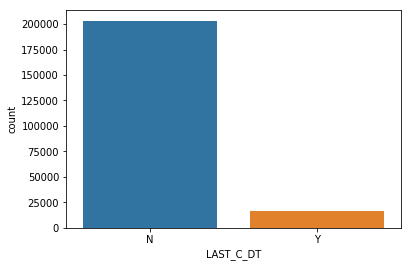

In [60]:
sns.countplot(train_test.loc[train_test["L1YR_C_CNT"].isnull(),"LAST_C_DT"])

In [51]:
train_test["L1YR_C_CNT"]=train_test["L1YR_C_CNT"].fillna(0)

In [15]:
for i in object_features:
    train_test = pd.concat([train_test, pd.get_dummies(train_test[i],prefix=i)], axis=1)
    del train_test[i]

## 使用隨機森林插補缺失值

In [18]:
float_null=pd.DataFrame([[i,train_test[i].isnull().sum()/len(train_test)] for i in float_features],columns=["variable","prop"])

In [19]:
missing_var=[]
for i in range(len(float_null)):
    if float_null["prop"][i]!=0:
        missing_var.append(float_null["variable"][i])

In [24]:
len(missing_var)

21

In [21]:
for i in tqdm(missing_var):
    k=[i]
    k.extend(train_test.drop([i for i in missing_var],axis=1).columns)
    train_test_use=train_test[[i for i in k]]
    train_test_use_train=train_test_use[train_test_use[i].notnull()].as_matrix()
    train_test_use_test=train_test_use[train_test_use[i].isnull()].as_matrix()
    y=train_test_use_train[:,0]
    x=train_test_use_train[:,1:]
    rfr = RandomForestRegressor(random_state=0, n_estimators=500, n_jobs=-1)
    rfr.fit(x, y)
    predict=rfr.predict(train_test_use_test[:,1:])
    train_test.loc[train_test[i].isnull(),i]=predict

C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\a2279\Anac

In [22]:
train_test.to_csv("train_impute.csv",encoding="big5",index=False)

In [23]:
train_test.shape

(250000, 268)

## 是否要加ANNUAL_PREMIUM_AMT變數

In [86]:
train_x=train_test[:100000]

In [29]:
train_y["Y1"]=train_y["Y1"].map({"N":0,"Y":1})

In [30]:
forest=RandomForestClassifier(criterion='entropy',n_estimators=1000,random_state=1,n_jobs=2)

In [32]:
skf = StratifiedShuffleSplit(n_splits=5)
for train_index, test_index in skf.split(train_x,train_y):
    X_train, X_test = train_x.loc[train_index], train_x.loc[test_index]
    y_train, y_test = train_y.loc[train_index], train_y.loc[test_index]
    forest.fit(X_train,y_train)
    y_predprob =forest.predict_proba(X_test)[:,1]
    print('Auc:%.3f' % (roc_auc_score(y_test, y_predprob)))

C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Auc:0.822


C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Auc:0.828


C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Auc:0.848


C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Auc:0.829


C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Auc:0.819


In [33]:
train_x1=train_x.drop(["ANNUAL_PREMIUM_AMT"],axis=1)

In [34]:
skf = StratifiedShuffleSplit(n_splits=5)
for train_index, test_index in skf.split(train_x1,train_y):
    X_train, X_test = train_x1.loc[train_index], train_x1.loc[test_index]
    y_train, y_test = train_y.loc[train_index], train_y.loc[test_index]
    forest.fit(X_train,y_train)
    y_predprob =forest.predict_proba(X_test)[:,1]
    print('Auc:%.3f' % (roc_auc_score(y_test, y_predprob)))

C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Auc:0.832


C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Auc:0.841


C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Auc:0.812


C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Auc:0.835


C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Auc:0.809


In [53]:
int_features = []
float_features = []
object_features = []

for dtype, feature in zip(train_test.dtypes,train_test.columns):
    if dtype == 'float64':
        float_features.append(feature)
    elif dtype == 'int64':
        int_features.append(feature)
    else:
        object_features.append(feature)
print(f'{len(int_features)} Integer Features : {int_features}\n')
print(f'{len(float_features)} Float Features : {float_features}\n')
print(f'{len(object_features)} Object Features : {object_features}')

11 Integer Features : ['L1YR_A_ISSUE_CNT', 'L1YR_B_ISSUE_CNT', 'CHANNEL_A_POL_CNT', 'CHANNEL_B_POL_CNT', 'APC_CNT', 'INSD_CNT', 'AG_CNT', 'AG_NOW_CNT', 'CLC_CUR_NUM', 'IM_CNT', 'TOOL_VISIT_1YEAR_CNT']

24 Float Features : ['APC_1ST_YEARDIF', 'ANNUAL_PREMIUM_AMT', 'ANNUAL_INCOME_AMT', 'BANK_NUMBER_CNT', 'INSD_LAST_YEARDIF_CNT', 'BMI', 'TERMINATION_RATE', 'DIEBENEFIT_AMT', 'DIEACCIDENT_AMT', 'POLICY_VALUE_AMT', 'ANNUITY_AMT', 'EXPIRATION_AMT', 'ACCIDENT_HOSPITAL_REC_AMT', 'DISEASES_HOSPITAL_REC_AMT', 'OUTPATIENT_SURGERY_AMT', 'INPATIENT_SURGERY_AMT', 'PAY_LIMIT_MED_MISC_AMT', 'FIRST_CANCER_AMT', 'ILL_ACCELERATION_AMT', 'ILL_ADDITIONAL_AMT', 'LONG_TERM_CARE_AMT', 'MONTHLY_CARE_AMT', 'LIFE_INSD_CNT', 'L1YR_GROSS_PRE_AMT']

95 Object Features : ['GENDER', 'AGE', 'CHARGE_CITY_CD', 'CONTACT_CITY_CD', 'EDUCATION_CD', 'MARRIAGE_CD', 'LAST_A_CCONTACT_DT', 'LAST_A_ISSUE_DT', 'LAST_B_ISSUE_DT', 'OCCUPATION_CLASS_CD', 'APC_1ST_AGE', 'INSD_1ST_AGE', 'IF_2ND_GEN_IND', 'RFM_R', 'REBUY_TIMES_CNT', 'LEV

In [ ]:
train_test["L1YR_C_CNT"]=train_test["L1YR_C_CNT"].astype(int)

In [54]:
train_test.to_csv("C:/Users/a2279/Desktop/國泰大數據/train_test.csv",encoding="big5",index=False)

## 處理離群值

In [53]:
f=[[0.1,0.6,0.3,0.4],[0.5,0.6,0.3,0.4],[0.9,0.6,0.3,0.4],[1.3,0.6,0.3,0.4],[0.1,0.1,0.3,0.4],[0.5,0.1,0.3,0.4],[0.9,0.1,0.3,0.4],[1.3,0.1,0.3,0.4]]

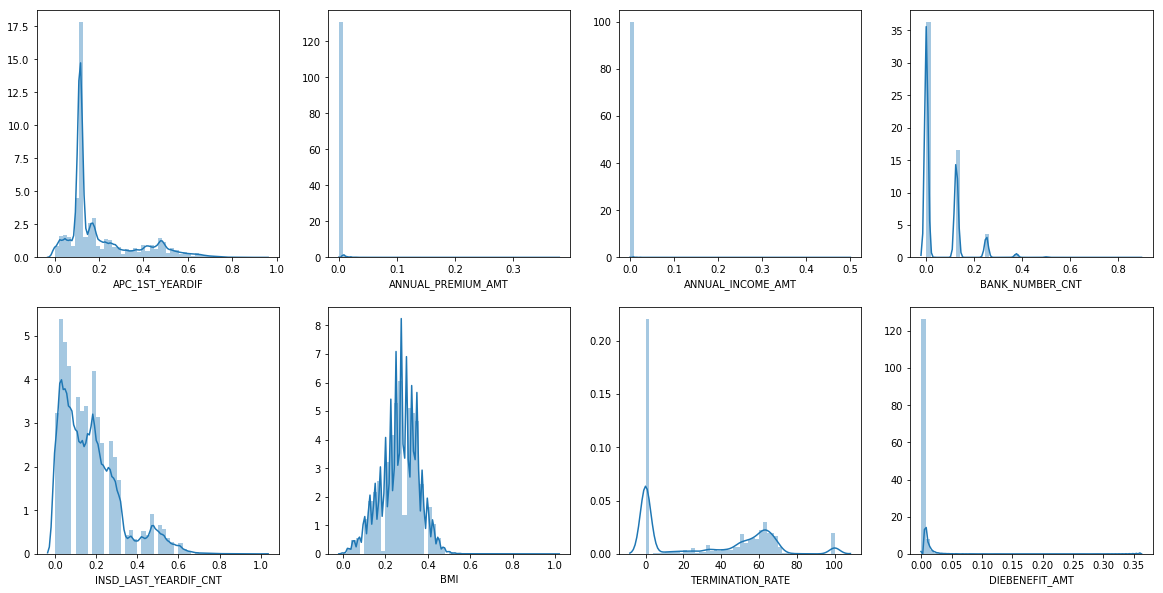

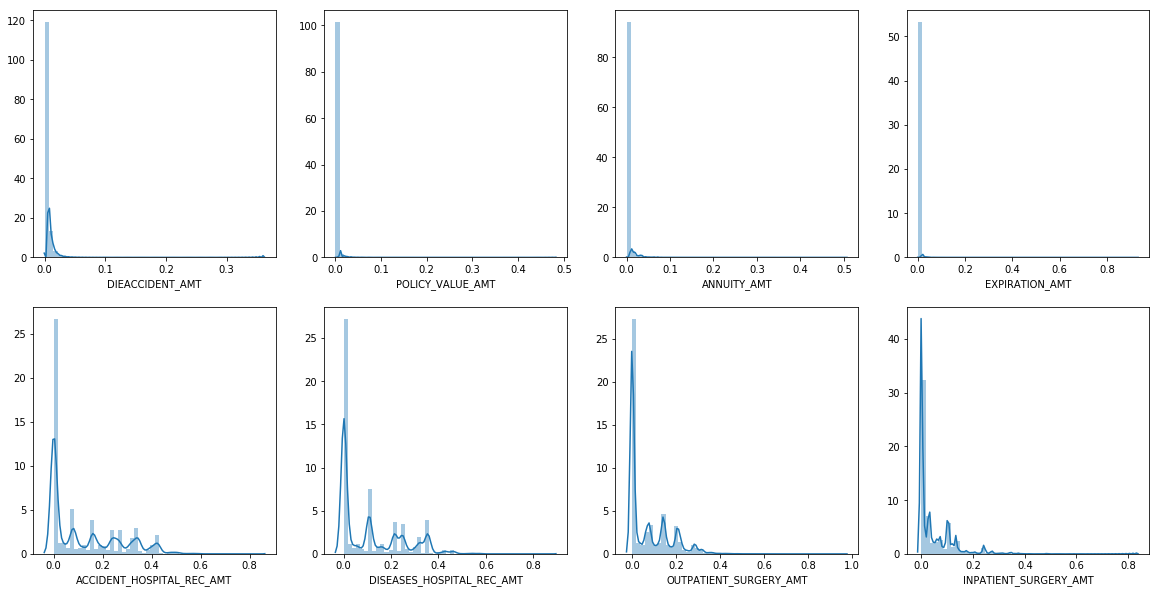

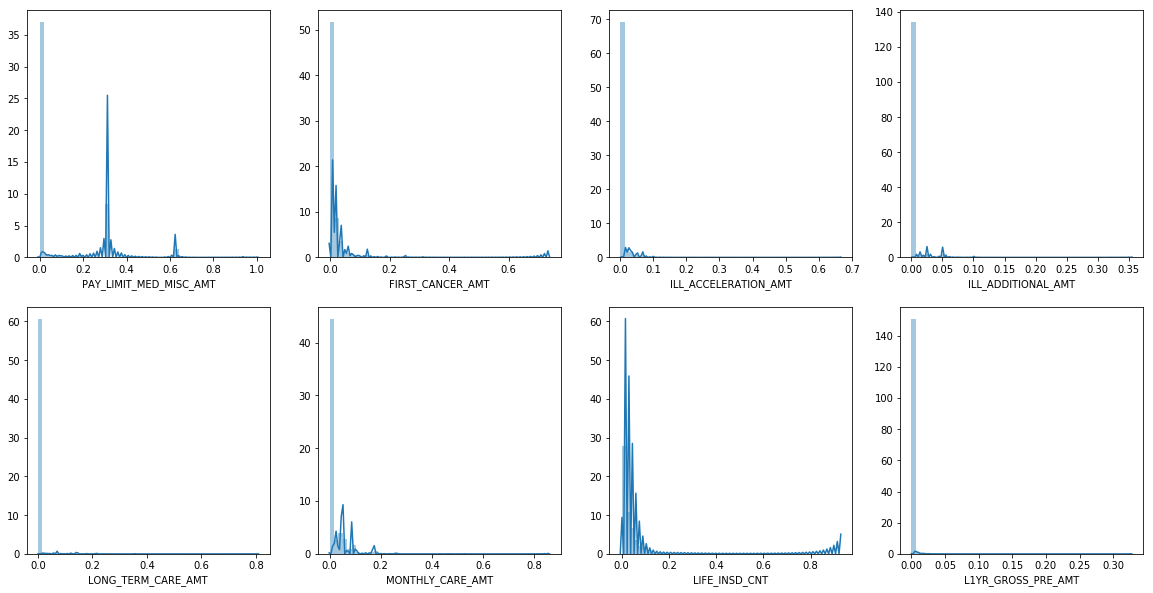

In [58]:
for i in np.arange(0,24,8):
    fig=plt.figure(figsize=(20,10))
    for j in np.arange(i,i+8,1):
        plt.subplot(2,4,j%8+1)
        sns.distplot(train_test[float_features[j]])
plt.show()

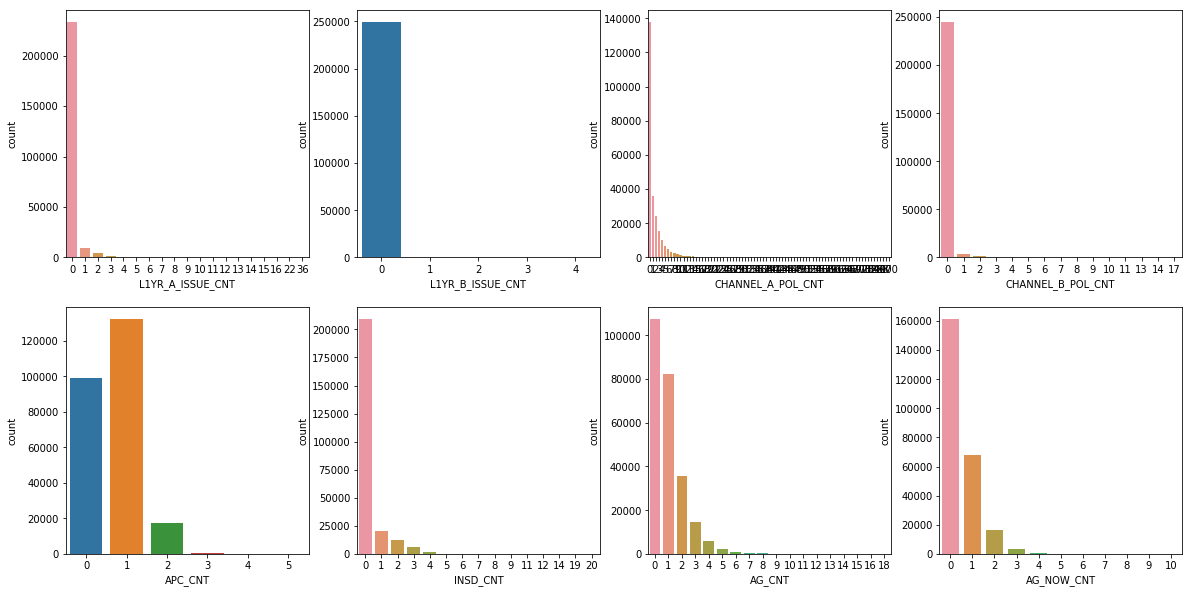

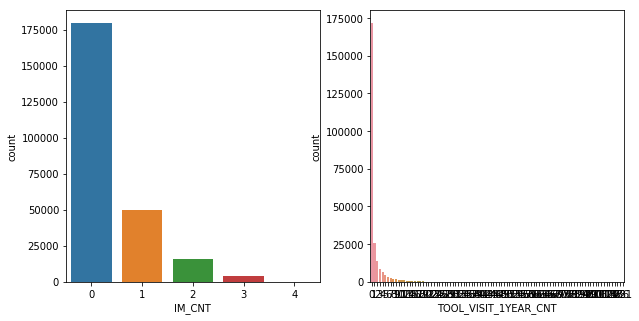

In [73]:
fig=plt.figure(figsize=(20,10))
for j in np.arange(0,8,1):
    plt.subplot(2,4,j+1)
    sns.countplot(train_test[int_features[j]])
plt.show()
fig=plt.figure(figsize=(10,5))
for k in np.arange(9,11,1):
    plt.subplot(1,2,k-8)
    sns.countplot(train_test[int_features[k]])
plt.show()

## boxcox轉換

In [91]:
train_test=pd.read_csv("train_impute.csv",encoding="big5")

In [97]:
train_test1=train_test[[i for i in float_features]]+0.00001

In [98]:
train=train_test1[0:100000]
test=train_test1[100000:]

In [99]:
train.describe()

,APC_1ST_YEARDIF,ANNUAL_PREMIUM_AMT,ANNUAL_INCOME_AMT,BANK_NUMBER_CNT,INSD_LAST_YEARDIF_CNT,BMI,TERMINATION_RATE,DIEBENEFIT_AMT,DIEACCIDENT_AMT,POLICY_VALUE_AMT,...,OUTPATIENT_SURGERY_AMT,INPATIENT_SURGERY_AMT,PAY_LIMIT_MED_MISC_AMT,FIRST_CANCER_AMT,ILL_ACCELERATION_AMT,ILL_ADDITIONAL_AMT,LONG_TERM_CARE_AMT,MONTHLY_CARE_AMT,LIFE_INSD_CNT,L1YR_GROSS_PRE_AMT
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.205997,0.000653,0.000551,0.056038,0.173012,0.267985,31.533223,0.002585,0.003609,0.000646,...,0.072510,0.046293,0.078789,0.012054,0.003216,0.001668,0.001906,0.015671,0.031483,0.000535
std,0.159223,0.002625,0.001240,0.084063,0.141647,0.087148,31.324255,0.005204,0.006176,0.004580,...,0.094567,0.070786,0.151393,0.029225,0.012206,0.008332,0.017405,0.035952,0.034269,0.003117
min,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,...,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010
25%,0.114307,0.000286,0.000248,0.000010,0.052642,0.225010,0.000010,0.000270,0.000384,0.000010,...,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.015635,0.000010
50%,0.118455,0.000286,0.000427,0.000010,0.157905,0.275010,33.053350,0.001027,0.001630,0.000010,...,0.008566,0.007361,0.000010,0.000127,0.000010,0.000010,0.000010,0.000010,0.015635,0.000010
75%,0.255824,0.000291,0.000635,0.125010,0.236852,0.325010,60.940015,0.002740,0.004376,0.000015,...,0.142867,0.072737,0.031885,0.013098,0.000012,0.000013,0.000010,0.010565,0.046885,0.000275
max,0.930243,0.378870,0.250010,0.875010,1.000010,0.925010,100.000010,0.362262,0.362262,0.378542,...,0.952391,0.824252,1.000010,0.734601,0.666677,0.300010,0.809534,0.859117,0.921885,0.327825


In [116]:
lam=dict()
for i in float_features:
    train_data,fitted_lambda = stats.boxcox(train[i])
    lam[i]=fitted_lambda
    test_data = stats.boxcox(test[i], fitted_lambda)
    train_test.loc[:99999,i]=train_data
    train_test.loc[100000:,i]=test_data

In [117]:
lam

{'APC_1ST_YEARDIF': 0.378482419110952,
 'ANNUAL_PREMIUM_AMT': -0.059536819195880844,
 'ANNUAL_INCOME_AMT': 0.02692525345157817,
 'BANK_NUMBER_CNT': -0.18253485858618648,
 'INSD_LAST_YEARDIF_CNT': 0.41685392292251033,
 'BMI': 1.1467552023824785,
 'TERMINATION_RATE': 0.044490680864457954,
 'DIEBENEFIT_AMT': 0.15988135758261424,
 'DIEACCIDENT_AMT': 0.19950664410414565,
 'POLICY_VALUE_AMT': -1.274765234793289,
 'ANNUITY_AMT': -0.42285279303840734,
 'EXPIRATION_AMT': -1.0647654687161665,
 'ACCIDENT_HOSPITAL_REC_AMT': 0.10612761029908345,
 'DISEASES_HOSPITAL_REC_AMT': 0.08214062345407268,
 'OUTPATIENT_SURGERY_AMT': 0.038809506285160146,
 'INPATIENT_SURGERY_AMT': 0.04271070756237458,
 'PAY_LIMIT_MED_MISC_AMT': -0.2648965620223151,
 'FIRST_CANCER_AMT': -0.06214522132382144,
 'ILL_ACCELERATION_AMT': -0.858088715747552,
 'ILL_ADDITIONAL_AMT': -1.201443474567141,
 'LONG_TERM_CARE_AMT': -2.679534382938886,
 'MONTHLY_CARE_AMT': -0.29032936659653924,
 'LIFE_INSD_CNT': 0.3346882185303625,
 'L1YR_GROS

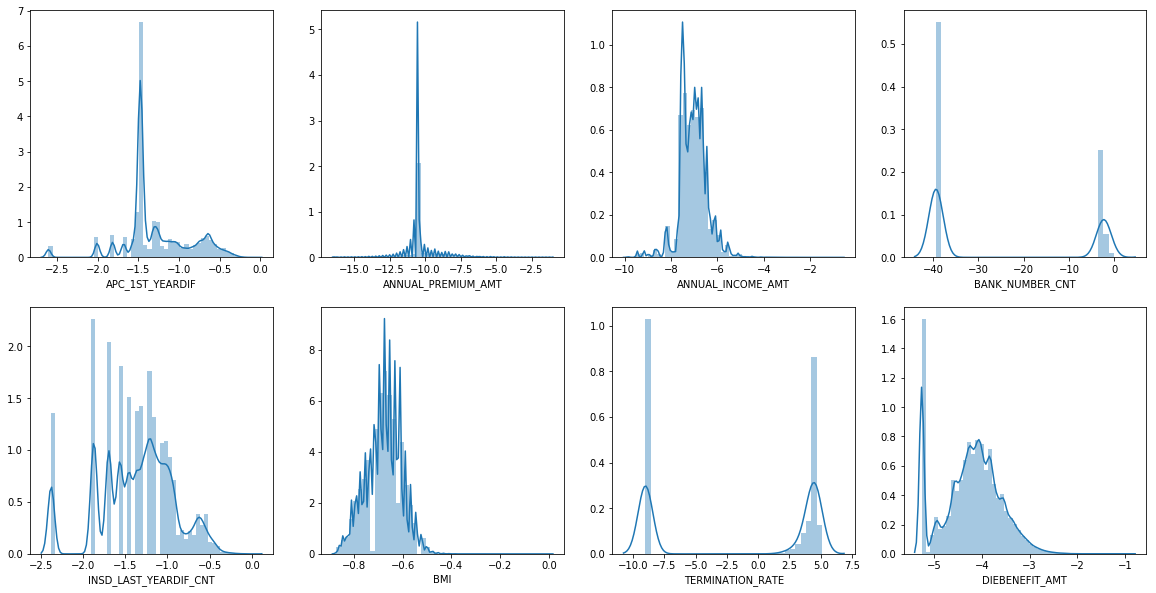

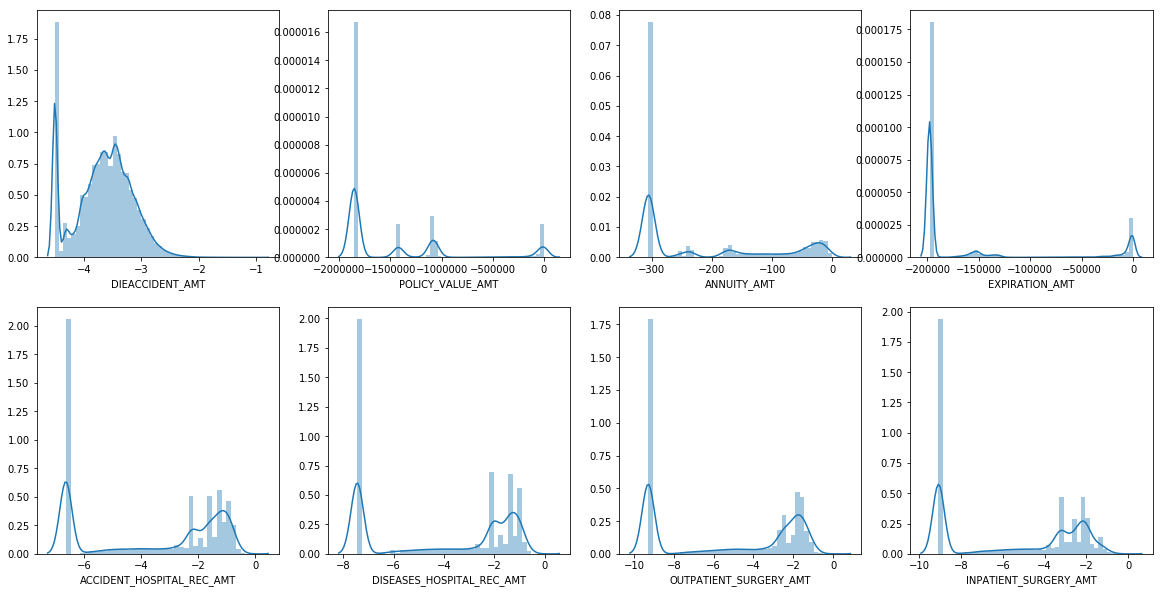

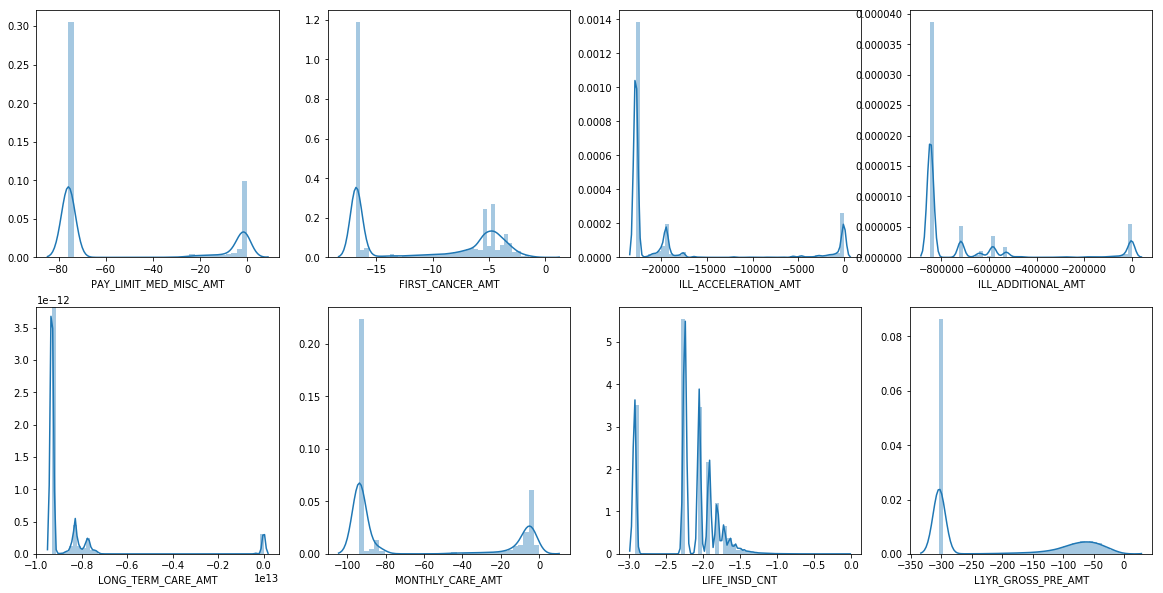

In [118]:
for i in np.arange(0,24,8):
    fig=plt.figure(figsize=(20,10))
    for j in np.arange(i,i+8,1):
        plt.subplot(2,4,j%8+1)
        sns.distplot(train_test[float_features[j]])
plt.show()

In [119]:
train_test.to_csv("train_test_boxcox.csv",encoding="big5",index=False)

## 是否對所有變數做boxcox轉換  

In [120]:
train_x=train_test[:100000]

In [121]:
forest=RandomForestClassifier(criterion='entropy',n_estimators=1000,random_state=1,n_jobs=2)

In [122]:
skf = StratifiedShuffleSplit(n_splits=5)
for train_index, test_index in skf.split(train_x,train_y):
    X_train, X_test = train_x.loc[train_index], train_x.loc[test_index]
    y_train, y_test = train_y.loc[train_index], train_y.loc[test_index]
    forest.fit(X_train,y_train)
    y_predprob =forest.predict_proba(X_test)[:,1]
    print('Auc:%.3f' % (roc_auc_score(y_test, y_predprob)))

C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Auc:0.826


C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Auc:0.843


C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Auc:0.827


C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Auc:0.830


C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Auc:0.820


In [4]:
train_y=pd.read_csv("train_y.csv",encoding="big5")

In [5]:
train_y["Y1"]=train_y["Y1"].map({"N":0,"Y":1})

In [9]:
train_test=pd.read_csv("train_test_boxcox.csv",encoding="big5")

In [10]:
train_x=train_test[:100000]

## 連續變數離散化

In [24]:
train_test=pd.read_csv("train_test_boxcox.csv",encoding="big5")

In [25]:
def discrete(df,variable,split_value):
    if df[variable]<split_value:
        df[variable]=0
    else:
        df[variable]=1
    return df

In [30]:
def discrete2(df,variable,split_value1,split_value2):
    if df[variable]<split_value1:
        df[variable]=0
    elif df[variable]>=split_value2:
        df[variable]=2
    else:
        df[variable]=1
    return df

In [31]:
def discrete3(df,variable,split_value1,split_value2,split_value3):
    if df[variable]<split_value1:
        df[variable]=0
    elif (df[variable]>=split_value1)&(df[variable]<split_value2):
        df[variable]=1
    elif df[variable]>=split_value3:
        df[variable]=3
    else:
        df[variable]=2
    return df

In [26]:
train_test=train_test.apply(discrete,args=["BANK_NUMBER_CNT",-20],axis=1)
train_test=train_test.apply(discrete,args=["TERMINATION_RATE",-2.5],axis=1)
train_test=train_test.apply(discrete,args=["PAY_LIMIT_MED_MISC_AMT",-40],axis=1)
train_test=train_test.apply(discrete,args=["MONTHLY_CARE_AMT",-50],axis=1)
train_test=train_test.apply(discrete,args=["L1YR_GROSS_PRE_AMT",-200],axis=1)

In [27]:
train_test.to_csv("train_test_boxcox_trans5.csv",encoding="big5",index=False)

In [28]:
train_test=train_test.apply(discrete,args=["DIEBENEFIT_AMT",-5],axis=1)
train_test=train_test.apply(discrete,args=["DIEACCIDENT_AMT",-4.3],axis=1)
train_test=train_test.apply(discrete,args=["ACCIDENT_HOSPITAL_REC_AMT",-6],axis=1)
train_test=train_test.apply(discrete,args=["DISEASES_HOSPITAL_REC_AMT",-6],axis=1)
train_test=train_test.apply(discrete,args=["OUTPATIENT_SURGERY_AMT",-8],axis=1)
train_test=train_test.apply(discrete,args=["INPATIENT_SURGERY_AMT",-8],axis=1)

In [29]:
train_test.to_csv("train_test_boxcox_trans11.csv",encoding="big5",index=False)

In [32]:
train_test=train_test.apply(discrete2,args=["EXPIRATION_AMT",-175000,-100000],axis=1)
train_test=train_test.apply(discrete2,args=["ILL_ACCELERATION_AMT",-22000,-10000],axis=1)
train_test=train_test.apply(discrete2,args=["LONG_TERM_CARE_AMT",-0.9,-0.4],axis=1)
train_test=train_test.apply(discrete3,args=["POLICY_VALUE_AMT",-1750000,-1250000,-500000],axis=1)
train_test=train_test.apply(discrete3,args=["ANNUITY_AMT",-280,-200,-100],axis=1)
train_test=train_test.apply(discrete3,args=["ILL_ADDITIONAL_AMT",-800000,-700000,-300000],axis=1)

In [33]:
train_test.to_csv("train_test_boxcox_trans17.csv",encoding="big5",index=False)

## 考慮均值編碼

In [33]:
train_test=pd.read_csv("train_test_boxcox_trans11.csv",encoding="big5")

In [34]:
train_test_old=pd.read_csv("train_test.csv",encoding="big5")

In [35]:
train_test_old["EDUCATION_CD"]=train_test_old["EDUCATION_CD"].astype("object")
train_test_old["MARRIAGE_CD"]=train_test_old["MARRIAGE_CD"].astype("object")
train_test_old["OCCUPATION_CLASS_CD"]=train_test_old["OCCUPATION_CLASS_CD"].astype("object")
train_test_old["LEVEL"]=train_test_old["LEVEL"].astype("object")
train_test_old["RFM_M_LEVEL"]=train_test_old["RFM_M_LEVEL"].astype("object")

In [36]:
int_features = []
float_features = []
object_features = []

for dtype, feature in zip(train_test_old.dtypes,train_test_old.columns):
    if dtype == 'float64':
        float_features.append(feature)
    elif dtype == 'int64':
        int_features.append(feature)
    else:
        object_features.append(feature)
print(f'{len(int_features)} Integer Features : {int_features}\n')
print(f'{len(float_features)} Float Features : {float_features}\n')
print(f'{len(object_features)} Object Features : {object_features}')

12 Integer Features : ['L1YR_A_ISSUE_CNT', 'L1YR_B_ISSUE_CNT', 'CHANNEL_A_POL_CNT', 'CHANNEL_B_POL_CNT', 'APC_CNT', 'INSD_CNT', 'AG_CNT', 'AG_NOW_CNT', 'CLC_CUR_NUM', 'L1YR_C_CNT', 'IM_CNT', 'TOOL_VISIT_1YEAR_CNT']

24 Float Features : ['APC_1ST_YEARDIF', 'ANNUAL_PREMIUM_AMT', 'ANNUAL_INCOME_AMT', 'BANK_NUMBER_CNT', 'INSD_LAST_YEARDIF_CNT', 'BMI', 'TERMINATION_RATE', 'DIEBENEFIT_AMT', 'DIEACCIDENT_AMT', 'POLICY_VALUE_AMT', 'ANNUITY_AMT', 'EXPIRATION_AMT', 'ACCIDENT_HOSPITAL_REC_AMT', 'DISEASES_HOSPITAL_REC_AMT', 'OUTPATIENT_SURGERY_AMT', 'INPATIENT_SURGERY_AMT', 'PAY_LIMIT_MED_MISC_AMT', 'FIRST_CANCER_AMT', 'ILL_ACCELERATION_AMT', 'ILL_ADDITIONAL_AMT', 'LONG_TERM_CARE_AMT', 'MONTHLY_CARE_AMT', 'LIFE_INSD_CNT', 'L1YR_GROSS_PRE_AMT']

94 Object Features : ['GENDER', 'AGE', 'CHARGE_CITY_CD', 'CONTACT_CITY_CD', 'EDUCATION_CD', 'MARRIAGE_CD', 'LAST_A_CCONTACT_DT', 'LAST_A_ISSUE_DT', 'LAST_B_ISSUE_DT', 'OCCUPATION_CLASS_CD', 'APC_1ST_AGE', 'INSD_1ST_AGE', 'IF_2ND_GEN_IND', 'RFM_R', 'REBUY_TI

In [37]:
train_y=pd.read_csv("train_y.csv")

In [38]:
train_y["Y1"]=train_y["Y1"].map({"N":0,"Y":1})

In [49]:
train_x=train_test_old[:100000]

In [50]:
train_x["y"]=train_y

C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
train_x.head()

,GENDER,AGE,CHARGE_CITY_CD,CONTACT_CITY_CD,EDUCATION_CD,MARRIAGE_CD,LAST_A_CCONTACT_DT,L1YR_A_ISSUE_CNT,LAST_A_ISSUE_DT,L1YR_B_ISSUE_CNT,...,L1YR_GROSS_PRE_AMT,CUST_9_SEGMENTS_CD,FINANCETOOLS_A,FINANCETOOLS_B,FINANCETOOLS_C,FINANCETOOLS_D,FINANCETOOLS_E,FINANCETOOLS_F,FINANCETOOLS_G,y
0,M,低,A1,A1,NaN,NaN,Y,0,N,0,...,0.000174,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,M,低,A1,A1,NaN,NaN,Y,0,N,0,...,0.008724,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,M,低,A1,A1,1.0,0.0,Y,1,Y,0,...,0.005359,A,Y,N,N,N,N,N,N,0
3,M,低,A1,A1,NaN,0.0,Y,0,N,0,...,0.000000,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,M,低,A1,A1,1.0,0.0,N,0,N,0,...,0.000603,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [41]:
for i in tqdm(int_features):
    a=train_x.groupby([i])["y"].mean()
    train_test[i]=pd.merge(train_test_old,a,left_on=i,right_index=True)["y"]

In [12]:
train_test.to_csv("train_test_boxcox_trans11_mean12.csv",encoding="big5",index=False)

In [13]:
int_features = []
float_features = []
object_features = []

for dtype, feature in zip(train_test.dtypes,train_test.columns):
    if dtype == 'float64':
        float_features.append(feature)
    elif dtype == 'int64':
        int_features.append(feature)
    else:
        object_features.append(feature)
print(f'{len(int_features)} Integer Features : {int_features}\n')
print(f'{len(float_features)} Float Features : {float_features}\n')
print(f'{len(object_features)} Object Features : {object_features}')

0 Integer Features : []

268 Float Features : ['L1YR_A_ISSUE_CNT', 'L1YR_B_ISSUE_CNT', 'CHANNEL_A_POL_CNT', 'CHANNEL_B_POL_CNT', 'APC_CNT', 'INSD_CNT', 'APC_1ST_YEARDIF', 'ANNUAL_PREMIUM_AMT', 'AG_CNT', 'AG_NOW_CNT', 'CLC_CUR_NUM', 'ANNUAL_INCOME_AMT', 'L1YR_C_CNT', 'BANK_NUMBER_CNT', 'INSD_LAST_YEARDIF_CNT', 'BMI', 'IM_CNT', 'TERMINATION_RATE', 'TOOL_VISIT_1YEAR_CNT', 'DIEBENEFIT_AMT', 'DIEACCIDENT_AMT', 'POLICY_VALUE_AMT', 'ANNUITY_AMT', 'EXPIRATION_AMT', 'ACCIDENT_HOSPITAL_REC_AMT', 'DISEASES_HOSPITAL_REC_AMT', 'OUTPATIENT_SURGERY_AMT', 'INPATIENT_SURGERY_AMT', 'PAY_LIMIT_MED_MISC_AMT', 'FIRST_CANCER_AMT', 'ILL_ACCELERATION_AMT', 'ILL_ADDITIONAL_AMT', 'LONG_TERM_CARE_AMT', 'MONTHLY_CARE_AMT', 'LIFE_INSD_CNT', 'L1YR_GROSS_PRE_AMT', 'GENDER_F', 'GENDER_M', 'AGE_中', 'AGE_中高', 'AGE_低', 'AGE_高', 'CHARGE_CITY_CD_A1', 'CHARGE_CITY_CD_A2', 'CHARGE_CITY_CD_B1', 'CHARGE_CITY_CD_B2', 'CHARGE_CITY_CD_C1', 'CHARGE_CITY_CD_C2', 'CHARGE_CITY_CD_D', 'CHARGE_CITY_CD_E', 'CONTACT_CITY_CD_A1', 'CONTAC

In [15]:
train_test=train_test.drop(['GENDER_F', 'GENDER_M', 'AGE_中', 'AGE_中高', 'AGE_低', 'AGE_高', 'CHARGE_CITY_CD_A1', 'CHARGE_CITY_CD_A2', 'CHARGE_CITY_CD_B1', 'CHARGE_CITY_CD_B2', 'CHARGE_CITY_CD_C1', 'CHARGE_CITY_CD_C2', 'CHARGE_CITY_CD_D', 'CHARGE_CITY_CD_E', 'CONTACT_CITY_CD_A1', 'CONTACT_CITY_CD_A2', 'CONTACT_CITY_CD_B1', 'CONTACT_CITY_CD_B2', 'CONTACT_CITY_CD_C1', 'CONTACT_CITY_CD_C2', 'CONTACT_CITY_CD_D', 'CONTACT_CITY_CD_E', 'EDUCATION_CD_1.0', 'EDUCATION_CD_2.0', 'EDUCATION_CD_3.0', 'EDUCATION_CD_4.0', 'MARRIAGE_CD_0.0', 'MARRIAGE_CD_1.0', 'MARRIAGE_CD_2.0'],axis=1)

In [16]:
for i in tqdm(['GENDER', 'AGE', 'CHARGE_CITY_CD', 'CONTACT_CITY_CD', 'EDUCATION_CD', 'MARRIAGE_CD']):
    a=train_x.groupby([i])["y"].mean()
    train_test[i]=pd.merge(train_test_old,a,left_on=i,right_index=True)["y"]

In [17]:
train_test.to_csv("train_test_boxcox_trans11_mean18.csv",encoding="big5",index=False)

In [26]:
train_test=pd.read_csv("train_test_boxcox_trans11_mean12.csv",encoding="big5")

In [42]:
train_test=train_test.drop(['LAST_A_CCONTACT_DT_N', 'LAST_A_CCONTACT_DT_Y', 'LAST_A_ISSUE_DT_N', 'LAST_A_ISSUE_DT_Y', 'LAST_B_ISSUE_DT_N', 'LAST_B_ISSUE_DT_Y', 'OCCUPATION_CLASS_CD_0.0', 'OCCUPATION_CLASS_CD_1.0', 'OCCUPATION_CLASS_CD_2.0', 'OCCUPATION_CLASS_CD_3.0', 'OCCUPATION_CLASS_CD_4.0', 'OCCUPATION_CLASS_CD_5.0', 'OCCUPATION_CLASS_CD_6.0', 'APC_1ST_AGE_中', 'APC_1ST_AGE_中高', 'APC_1ST_AGE_低', 'APC_1ST_AGE_高', 'INSD_1ST_AGE_中', 'INSD_1ST_AGE_中高', 'INSD_1ST_AGE_低', 'INSD_1ST_AGE_高'],axis=1)

In [43]:
for i in tqdm(['IF_ISSUE_A_IND', 'IF_ISSUE_B_IND', 'IF_ISSUE_C_IND', 'IF_ISSUE_D_IND', 'IF_ISSUE_E_IND', 'IF_ISSUE_F_IND', 'IF_ISSUE_G_IND', 'IF_ISSUE_H_IND', 'IF_ISSUE_I_IND', 'IF_ISSUE_J_IND', 'IF_ISSUE_K_IND', 'IF_ISSUE_L_IND', 'IF_ISSUE_M_IND', 'IF_ISSUE_N_IND', 'IF_ISSUE_O_IND', 'IF_ISSUE_P_IND', 'IF_ISSUE_Q_IND']):
    a=train_x.groupby([i])["y"].mean()
    train_test[i]=pd.merge(train_test_old,a,left_on=i,right_index=True)["y"]

In [29]:
train_test.to_csv("train_test_boxcox_trans11_mean18.csv",encoding="big5",index=False)

In [30]:
train_test=train_test.drop(['IF_2ND_GEN_IND_N', 'IF_2ND_GEN_IND_Y', 'RFM_R_中', 'RFM_R_中高', 'RFM_R_低', 'RFM_R_高', 'REBUY_TIMES_CNT_中', 'REBUY_TIMES_CNT_中高', 'REBUY_TIMES_CNT_低', 'REBUY_TIMES_CNT_高', 'LEVEL_1.0', 'LEVEL_2.0', 'LEVEL_3.0', 'LEVEL_4.0', 'LEVEL_5.0', 'RFM_M_LEVEL_3.0', 'RFM_M_LEVEL_5.0', 'RFM_M_LEVEL_7.0', 'RFM_M_LEVEL_8.0', 'RFM_M_LEVEL_9.0', 'RFM_M_LEVEL_10.0', 'LIFE_CNT_中', 'LIFE_CNT_低', 'LIFE_CNT_高'],axis=1)

In [31]:
for i in tqdm(['IF_2ND_GEN_IND', 'RFM_R', 'REBUY_TIMES_CNT', 'LEVEL', 'RFM_M_LEVEL', 'LIFE_CNT']):
    a=train_x.groupby([i])["y"].mean()
    train_test[i]=pd.merge(train_test_old,a,left_on=i,right_index=True)["y"]

In [32]:
train_test.to_csv("train_test_boxcox_trans11_mean24.csv",encoding="big5",index=False)

In [48]:
train_test=pd.read_csv("train_test_boxcox_trans11_mean18.csv",encoding="big5")

In [49]:
train_test=train_test.drop(['IF_ISSUE_A_IND_N', 'IF_ISSUE_A_IND_Y', 'IF_ISSUE_B_IND_N', 'IF_ISSUE_B_IND_Y', 'IF_ISSUE_C_IND_N', 'IF_ISSUE_C_IND_Y', 'IF_ISSUE_D_IND_N', 'IF_ISSUE_D_IND_Y', 'IF_ISSUE_E_IND_N', 'IF_ISSUE_E_IND_Y', 'IF_ISSUE_F_IND_N', 'IF_ISSUE_F_IND_Y', 'IF_ISSUE_G_IND_N', 'IF_ISSUE_G_IND_Y', 'IF_ISSUE_H_IND_N', 'IF_ISSUE_H_IND_Y', 'IF_ISSUE_I_IND_N', 'IF_ISSUE_I_IND_Y', 'IF_ISSUE_J_IND_N', 'IF_ISSUE_J_IND_Y', 'IF_ISSUE_K_IND_N', 'IF_ISSUE_K_IND_Y', 'IF_ISSUE_L_IND_N', 'IF_ISSUE_L_IND_Y', 'IF_ISSUE_M_IND_N', 'IF_ISSUE_M_IND_Y', 'IF_ISSUE_N_IND_N', 'IF_ISSUE_N_IND_Y', 'IF_ISSUE_O_IND_N', 'IF_ISSUE_O_IND_Y', 'IF_ISSUE_P_IND_N', 'IF_ISSUE_P_IND_Y', 'IF_ISSUE_Q_IND_N', 'IF_ISSUE_Q_IND_Y'],axis=1)

In [50]:
for i in tqdm(['IF_ISSUE_A_IND', 'IF_ISSUE_B_IND', 'IF_ISSUE_C_IND', 'IF_ISSUE_D_IND', 'IF_ISSUE_E_IND', 'IF_ISSUE_F_IND', 'IF_ISSUE_G_IND', 'IF_ISSUE_H_IND', 'IF_ISSUE_I_IND', 'IF_ISSUE_J_IND', 'IF_ISSUE_K_IND', 'IF_ISSUE_L_IND', 'IF_ISSUE_M_IND', 'IF_ISSUE_N_IND', 'IF_ISSUE_O_IND', 'IF_ISSUE_P_IND', 'IF_ISSUE_Q_IND']):
    a=train_x.groupby([i])["y"].mean()
    train_test[i]=pd.merge(train_test_old,a,left_on=i,right_index=True)["y"]

In [53]:
train_test.head()

,L1YR_A_ISSUE_CNT,L1YR_B_ISSUE_CNT,CHANNEL_A_POL_CNT,CHANNEL_B_POL_CNT,APC_CNT,INSD_CNT,APC_1ST_YEARDIF,ANNUAL_PREMIUM_AMT,AG_CNT,AG_NOW_CNT,...,IF_ISSUE_H_IND,IF_ISSUE_I_IND,IF_ISSUE_J_IND,IF_ISSUE_K_IND,IF_ISSUE_L_IND,IF_ISSUE_M_IND,IF_ISSUE_N_IND,IF_ISSUE_O_IND,IF_ISSUE_P_IND,IF_ISSUE_Q_IND
0,0.015905,0.019962,0.008065,0.019966,0.025019,0.015872,-1.814789,-11.076881,0.025714,0.009642,...,0.019987,0.016477,0.016332,0.019971,0.019796,0.02,0.033792,0.020023,0.017016,0.013494
1,0.015905,0.019962,0.008065,0.019966,0.025019,0.015872,-1.814789,-5.340448,0.025714,0.009642,...,0.019987,0.016477,0.016332,0.019971,0.019796,0.02,0.017543,0.020023,0.036879,0.013494
2,0.060731,0.019962,0.025290,0.019966,0.016683,0.015872,-2.608282,-10.416287,0.025714,0.009642,...,0.019987,0.016477,0.016332,0.019971,0.019796,0.02,0.033792,0.020023,0.017016,0.013494
3,0.015905,0.019962,0.008065,0.019966,0.025019,0.015872,-1.312962,-10.508211,0.025714,0.009642,...,0.019987,0.016477,0.016332,0.019971,0.019796,0.02,0.017543,0.020023,0.036879,0.013494
4,0.015905,0.019962,0.025290,0.019966,0.016683,0.015872,-1.471885,-9.147221,0.025714,0.036090,...,0.019987,0.016477,0.016332,0.019971,0.019796,0.02,0.033792,0.020023,0.017016,0.013494


In [54]:
train_x.groupby(['IF_ISSUE_A_IND'])["y"].mean()

IF_ISSUE_A_IND
N    0.019832
Y    0.028769
Name: y, dtype: float64

In [52]:
train_test.to_csv("train_test_boxcox_trans11_mean35.csv",encoding="big5",index=False)

In [51]:
train_test.shape

(250000, 236)

In [30]:
train_test=train_test.drop(['IF_ADD_F_IND_N', 'IF_ADD_F_IND_Y', 'IF_ADD_L_IND_N', 'IF_ADD_L_IND_Y', 'IF_ADD_Q_IND_N', 'IF_ADD_Q_IND_Y', 'IF_ADD_G_IND_N', 'IF_ADD_G_IND_Y', 'IF_ADD_R_IND_N', 'IF_ADD_R_IND_Y', 'IF_ADD_IND_N', 'IF_ADD_IND_Y'],axis=1)

In [31]:
for i in tqdm(['IF_ADD_F_IND', 'IF_ADD_L_IND', 'IF_ADD_Q_IND', 'IF_ADD_G_IND', 'IF_ADD_R_IND', 'IF_ADD_IND']):
    a=train_x.groupby([i])["y"].mean()
    train_test[i]=pd.merge(train_test_old,a,left_on=i,right_index=True)["y"]

In [32]:
train_test.to_csv("train_test_boxcox_trans11_mean41.csv",encoding="big5",index=False)

In [29]:
train_test=pd.read_csv("train_test_boxcox_trans11_mean35.csv",encoding="big5")

In [49]:
train_test=train_test.drop(['L1YR_PAYMENT_REMINDER_IND_N', 'L1YR_PAYMENT_REMINDER_IND_Y', 'L1YR_LAPSE_IND_N', 'L1YR_LAPSE_IND_Y', 'LAST_B_CONTACT_DT_N', 'LAST_B_CONTACT_DT_Y', 'A_IND_N', 'A_IND_Y', 'B_IND_N', 'B_IND_Y', 'C_IND_N', 'C_IND_Y'],axis=1)

In [50]:
for i in tqdm(['L1YR_PAYMENT_REMINDER_IND', 'L1YR_LAPSE_IND', 'LAST_B_CONTACT_DT', 'A_IND', 'B_IND', 'C_IND']):
    a=train_x.groupby([i])["y"].mean()
    train_test[i]=pd.merge(train_test_old,a,left_on=i,right_index=True)["y"]

In [51]:
train_test.to_csv("train_test_boxcox_trans11_mean41.csv",encoding="big5",index=False)

In [53]:
train_test=pd.read_csv("train_test_boxcox_trans11_mean35.csv",encoding="big5")

In [54]:
train_test=train_test.drop(['LAST_C_DT_N', 'LAST_C_DT_Y', 'IF_S_REAL_IND_N', 'IF_S_REAL_IND_Y', 'IF_Y_REAL_IND_N', 'IF_Y_REAL_IND_Y', 'IM_IS_A_IND_N', 'IM_IS_A_IND_Y', 'IM_IS_B_IND_N', 'IM_IS_B_IND_Y', 'IM_IS_C_IND_N', 'IM_IS_C_IND_Y', 'IM_IS_D_IND_N', 'IM_IS_D_IND_Y'],axis=1)

In [55]:
for i in tqdm(['LAST_C_DT', 'IF_S_REAL_IND', 'IF_Y_REAL_IND', 'IM_IS_A_IND', 'IM_IS_B_IND', 'IM_IS_C_IND', 'IM_IS_D_IND']):
    a=train_x.groupby([i])["y"].mean()
    train_test[i]=pd.merge(train_test_old,a,left_on=i,right_index=True)["y"]

In [56]:
train_test.to_csv("train_test_boxcox_trans11_mean42.csv",encoding="big5",index=False)

In [57]:
train_test=pd.read_csv("train_test_boxcox_trans11_mean35.csv",encoding="big5")

In [58]:
train_test=train_test.drop(['X_A_IND_N', 'X_A_IND_Y', 'X_B_IND_N', 'X_B_IND_Y', 'X_C_IND_N', 'X_C_IND_Y', 'X_D_IND_N', 'X_D_IND_Y', 'X_E_IND_N', 'X_E_IND_Y', 'X_F_IND_N', 'X_F_IND_Y', 'X_G_IND_N', 'X_G_IND_Y', 'X_H_IND_N', 'X_H_IND_Y', 'IF_HOUSEHOLD_CLAIM_IND_N', 'IF_HOUSEHOLD_CLAIM_IND_Y'],axis=1)

In [59]:
for i in tqdm(['X_A_IND', 'X_B_IND', 'X_C_IND', 'X_D_IND', 'X_E_IND', 'X_F_IND', 'X_G_IND', 'X_H_IND', 'IF_HOUSEHOLD_CLAIM_IND']):
    a=train_x.groupby([i])["y"].mean()
    train_test[i]=pd.merge(train_test_old,a,left_on=i,right_index=True)["y"]

In [60]:
train_test.to_csv("train_test_boxcox_trans11_mean43.csv",encoding="big5",index=False)

In [61]:
train_test=pd.read_csv("train_test_boxcox_trans11_mean35.csv",encoding="big5")

In [62]:
train_test=train_test.drop(['IF_ISSUE_INSD_A_IND_N', 'IF_ISSUE_INSD_A_IND_Y', 'IF_ISSUE_INSD_B_IND_N', 'IF_ISSUE_INSD_B_IND_Y', 'IF_ISSUE_INSD_C_IND_N', 'IF_ISSUE_INSD_C_IND_Y', 'IF_ISSUE_INSD_D_IND_N', 'IF_ISSUE_INSD_D_IND_Y', 'IF_ISSUE_INSD_E_IND_N', 'IF_ISSUE_INSD_E_IND_Y', 'IF_ISSUE_INSD_F_IND_N', 'IF_ISSUE_INSD_F_IND_Y', 'IF_ISSUE_INSD_G_IND_N', 'IF_ISSUE_INSD_G_IND_Y', 'IF_ISSUE_INSD_H_IND_N', 'IF_ISSUE_INSD_H_IND_Y', 'IF_ISSUE_INSD_I_IND_N', 'IF_ISSUE_INSD_I_IND_Y', 'IF_ISSUE_INSD_J_IND_N', 'IF_ISSUE_INSD_J_IND_Y', 'IF_ISSUE_INSD_K_IND_N', 'IF_ISSUE_INSD_K_IND_Y', 'IF_ISSUE_INSD_L_IND_N', 'IF_ISSUE_INSD_L_IND_Y', 'IF_ISSUE_INSD_M_IND_N', 'IF_ISSUE_INSD_M_IND_Y', 'IF_ISSUE_INSD_N_IND_N', 'IF_ISSUE_INSD_N_IND_Y', 'IF_ISSUE_INSD_O_IND_N', 'IF_ISSUE_INSD_O_IND_Y', 'IF_ISSUE_INSD_P_IND_N', 'IF_ISSUE_INSD_P_IND_Y', 'IF_ISSUE_INSD_Q_IND_N', 'IF_ISSUE_INSD_Q_IND_Y'],axis=1)

In [63]:
for i in tqdm(['IF_ISSUE_INSD_A_IND', 'IF_ISSUE_INSD_B_IND', 'IF_ISSUE_INSD_C_IND', 'IF_ISSUE_INSD_D_IND', 'IF_ISSUE_INSD_E_IND', 'IF_ISSUE_INSD_F_IND', 'IF_ISSUE_INSD_G_IND', 'IF_ISSUE_INSD_H_IND', 'IF_ISSUE_INSD_I_IND', 'IF_ISSUE_INSD_J_IND', 'IF_ISSUE_INSD_K_IND', 'IF_ISSUE_INSD_L_IND', 'IF_ISSUE_INSD_M_IND', 'IF_ISSUE_INSD_N_IND', 'IF_ISSUE_INSD_O_IND', 'IF_ISSUE_INSD_P_IND', 'IF_ISSUE_INSD_Q_IND']):
    a=train_x.groupby([i])["y"].mean()
    train_test[i]=pd.merge(train_test_old,a,left_on=i,right_index=True)["y"]

In [64]:
train_test.to_csv("train_test_boxcox_trans11_mean52.csv",encoding="big5",index=False)

In [65]:
train_test=pd.read_csv("train_test_boxcox_trans11_mean35.csv",encoding="big5")

In [66]:
train_test=train_test.drop(['IF_ADD_INSD_F_IND_N', 'IF_ADD_INSD_F_IND_Y', 'IF_ADD_INSD_L_IND_N', 'IF_ADD_INSD_L_IND_Y', 'IF_ADD_INSD_Q_IND_N', 'IF_ADD_INSD_Q_IND_Y', 'IF_ADD_INSD_G_IND_N', 'IF_ADD_INSD_G_IND_Y', 'IF_ADD_INSD_R_IND_N', 'IF_ADD_INSD_R_IND_Y', 'IF_ADD_INSD_IND_N', 'IF_ADD_INSD_IND_Y', 'CUST_9_SEGMENTS_CD_A', 'CUST_9_SEGMENTS_CD_B', 'CUST_9_SEGMENTS_CD_C', 'CUST_9_SEGMENTS_CD_D', 'CUST_9_SEGMENTS_CD_E', 'CUST_9_SEGMENTS_CD_F', 'CUST_9_SEGMENTS_CD_G', 'CUST_9_SEGMENTS_CD_H'],axis=1)

In [67]:
for i in tqdm(['IF_ADD_INSD_F_IND', 'IF_ADD_INSD_L_IND', 'IF_ADD_INSD_Q_IND', 'IF_ADD_INSD_G_IND', 'IF_ADD_INSD_R_IND', 'IF_ADD_INSD_IND', 'CUST_9_SEGMENTS_CD']):
    a=train_x.groupby([i])["y"].mean()
    train_test[i]=pd.merge(train_test_old,a,left_on=i,right_index=True)["y"]

In [68]:
train_test.to_csv("train_test_boxcox_trans11_mean42.csv",encoding="big5",index=False)

In [69]:
train_test=pd.read_csv("train_test_boxcox_trans11_mean35.csv",encoding="big5")

In [70]:
train_test=train_test.drop(['FINANCETOOLS_A_N', 'FINANCETOOLS_A_Y', 'FINANCETOOLS_B_N', 'FINANCETOOLS_B_Y', 'FINANCETOOLS_C_N', 'FINANCETOOLS_C_Y', 'FINANCETOOLS_D_N', 'FINANCETOOLS_D_Y', 'FINANCETOOLS_E_N', 'FINANCETOOLS_E_Y', 'FINANCETOOLS_F_N', 'FINANCETOOLS_F_Y', 'FINANCETOOLS_G_N', 'FINANCETOOLS_G_Y'],axis=1)

In [71]:
for i in tqdm(['FINANCETOOLS_A', 'FINANCETOOLS_B', 'FINANCETOOLS_C', 'FINANCETOOLS_D', 'FINANCETOOLS_E', 'FINANCETOOLS_F', 'FINANCETOOLS_G']):
    a=train_x.groupby([i])["y"].mean()
    train_test[i]=pd.merge(train_test_old,a,left_on=i,right_index=True)["y"]

In [72]:
train_test.to_csv("train_test_boxcox_trans11_mean41.csv",encoding="big5",index=False)

## 計數編碼

In [2]:
train_test_old=pd.read_csv("train_test.csv",encoding="big5")

C:\Users\a2279\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (16,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
import matplotlib.font_manager as fm
fontPath='C:/作品集/交通意外事故/app4/NotoSerifCJKtc-Regular.otf'
font10 = fm.FontProperties(fname=fontPath, size=10)

In [39]:
len(object_features)

94

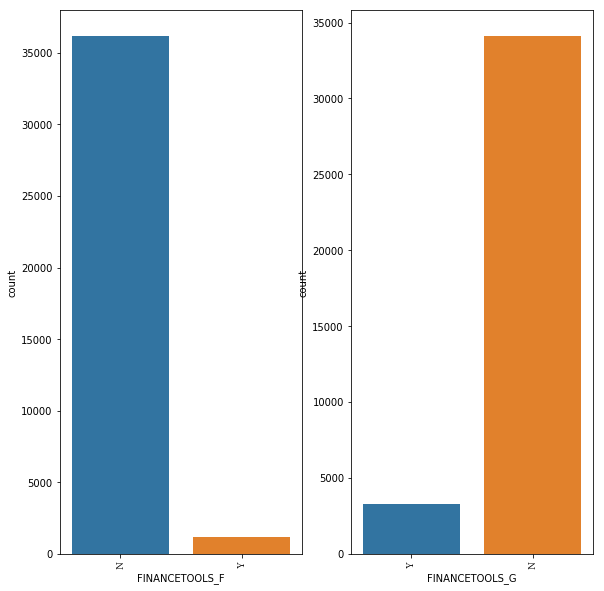

In [41]:
plt.figure(figsize=(20,10))
for i in np.arange(92,94):
    k=object_features[i]
    a=train_x.groupby([k])["y"].mean()
    plt.subplot(1,4,i-91)
    sns.countplot(k,data=train_x,order=a.sort_values().index)
    plt.xticks(rotation=90,fontproperties=font10)

In [59]:
data=pd.read_csv("train_test_boxcox_trans11_mean35.csv",encoding="big5")

In [43]:
train_x['IM_CNT'].value_counts()

0    71780
1    19964
2     6414
3     1782
4       60
Name: IM_CNT, dtype: int64

In [45]:
data.head()

,L1YR_A_ISSUE_CNT,L1YR_B_ISSUE_CNT,CHANNEL_A_POL_CNT,CHANNEL_B_POL_CNT,APC_CNT,INSD_CNT,APC_1ST_YEARDIF,ANNUAL_PREMIUM_AMT,AG_CNT,AG_NOW_CNT,...,IF_ISSUE_H_IND,IF_ISSUE_I_IND,IF_ISSUE_J_IND,IF_ISSUE_K_IND,IF_ISSUE_L_IND,IF_ISSUE_M_IND,IF_ISSUE_N_IND,IF_ISSUE_O_IND,IF_ISSUE_P_IND,IF_ISSUE_Q_IND
0,0.015905,0.019962,0.008065,0.019966,0.025019,0.015872,-1.814789,-11.076881,0.025714,0.009642,...,0.019987,0.016477,0.016332,0.019971,0.019796,0.02,0.033792,0.020023,0.017016,0.013494
1,0.015905,0.019962,0.008065,0.019966,0.025019,0.015872,-1.814789,-5.340448,0.025714,0.009642,...,0.019987,0.016477,0.016332,0.019971,0.019796,0.02,0.017543,0.020023,0.036879,0.013494
2,0.060731,0.019962,0.025290,0.019966,0.016683,0.015872,-2.608282,-10.416287,0.025714,0.009642,...,0.019987,0.016477,0.016332,0.019971,0.019796,0.02,0.033792,0.020023,0.017016,0.013494
3,0.015905,0.019962,0.008065,0.019966,0.025019,0.015872,-1.312962,-10.508211,0.025714,0.009642,...,0.019987,0.016477,0.016332,0.019971,0.019796,0.02,0.017543,0.020023,0.036879,0.013494
4,0.015905,0.019962,0.025290,0.019966,0.016683,0.015872,-1.471885,-9.147221,0.025714,0.036090,...,0.019987,0.016477,0.016332,0.019971,0.019796,0.02,0.033792,0.020023,0.017016,0.013494


In [53]:
int_features = []
float_features = []
object_features = []

for dtype, feature in zip(data.dtypes,data.columns):
    if dtype == 'float64':
        float_features.append(feature)
    elif dtype == 'int64':
        int_features.append(feature)
    else:
        object_features.append(feature)
print(f'{len(int_features)} Integer Features : {int_features}\n')
print(f'{len(float_features)} Float Features : {float_features}\n')
print(f'{len(object_features)} Object Features : {object_features}')

0 Integer Features : []

236 Float Features : ['L1YR_A_ISSUE_CNT', 'L1YR_B_ISSUE_CNT', 'CHANNEL_A_POL_CNT', 'CHANNEL_B_POL_CNT', 'APC_CNT', 'INSD_CNT', 'APC_1ST_YEARDIF', 'ANNUAL_PREMIUM_AMT', 'AG_CNT', 'AG_NOW_CNT', 'CLC_CUR_NUM', 'ANNUAL_INCOME_AMT', 'L1YR_C_CNT', 'BANK_NUMBER_CNT', 'INSD_LAST_YEARDIF_CNT', 'BMI', 'IM_CNT', 'TERMINATION_RATE', 'TOOL_VISIT_1YEAR_CNT', 'DIEBENEFIT_AMT', 'DIEACCIDENT_AMT', 'POLICY_VALUE_AMT', 'ANNUITY_AMT', 'EXPIRATION_AMT', 'ACCIDENT_HOSPITAL_REC_AMT', 'DISEASES_HOSPITAL_REC_AMT', 'OUTPATIENT_SURGERY_AMT', 'INPATIENT_SURGERY_AMT', 'PAY_LIMIT_MED_MISC_AMT', 'FIRST_CANCER_AMT', 'ILL_ACCELERATION_AMT', 'ILL_ADDITIONAL_AMT', 'LONG_TERM_CARE_AMT', 'MONTHLY_CARE_AMT', 'LIFE_INSD_CNT', 'L1YR_GROSS_PRE_AMT', 'GENDER_F', 'GENDER_M', 'AGE_中', 'AGE_中高', 'AGE_低', 'AGE_高', 'CHARGE_CITY_CD_A1', 'CHARGE_CITY_CD_A2', 'CHARGE_CITY_CD_B1', 'CHARGE_CITY_CD_B2', 'CHARGE_CITY_CD_C1', 'CHARGE_CITY_CD_C2', 'CHARGE_CITY_CD_D', 'CHARGE_CITY_CD_E', 'CONTACT_CITY_CD_A1', 'CONTAC

In [60]:
data["GENDER"]=pd.merge(train_test_old,train_x["GENDER"].value_counts(),left_on="GENDER",right_index=True)["GENDER_y"]
data["LAST_A_CCONTACT_DT"]=pd.merge(train_test_old,train_x["LAST_A_CCONTACT_DT"].value_counts(),left_on="LAST_A_CCONTACT_DT",right_index=True)["LAST_A_CCONTACT_DT_y"]
data["LAST_A_ISSUE_DT"]=pd.merge(train_test_old,train_x["LAST_A_ISSUE_DT"].value_counts(),left_on="LAST_A_ISSUE_DT",right_index=True)["LAST_A_ISSUE_DT_y"]
data["LAST_B_ISSUE_DT"]=pd.merge(train_test_old,train_x["LAST_B_ISSUE_DT"].value_counts(),left_on="LAST_B_ISSUE_DT",right_index=True)["LAST_B_ISSUE_DT_y"]
data["IF_2ND_GEN_IND"]=pd.merge(train_test_old,train_x["IF_2ND_GEN_IND"].value_counts(),left_on="IF_2ND_GEN_IND",right_index=True)["IF_2ND_GEN_IND_y"]

In [55]:
data=data.drop(['GENDER_F', 'GENDER_M','IF_2ND_GEN_IND_N', 'IF_2ND_GEN_IND_Y'],axis=1)

In [61]:
data.to_csv("train_test_boxcox_trans11_mean35_count5.csv",encoding="big5",index=False)

## 相關係數矩陣

In [62]:
data=pd.read_csv("train_test_boxcox_trans11_mean35.csv",encoding="big5")

In [63]:
int_features = []
float_features = []
object_features = []

for dtype, feature in zip(data.dtypes,data.columns):
    if dtype == 'float64':
        float_features.append(feature)
    elif dtype == 'int64':
        int_features.append(feature)
    else:
        object_features.append(feature)
print(f'{len(int_features)} Integer Features : {int_features}\n')
print(f'{len(float_features)} Float Features : {float_features}\n')
print(f'{len(object_features)} Object Features : {object_features}')

0 Integer Features : []

236 Float Features : ['L1YR_A_ISSUE_CNT', 'L1YR_B_ISSUE_CNT', 'CHANNEL_A_POL_CNT', 'CHANNEL_B_POL_CNT', 'APC_CNT', 'INSD_CNT', 'APC_1ST_YEARDIF', 'ANNUAL_PREMIUM_AMT', 'AG_CNT', 'AG_NOW_CNT', 'CLC_CUR_NUM', 'ANNUAL_INCOME_AMT', 'L1YR_C_CNT', 'BANK_NUMBER_CNT', 'INSD_LAST_YEARDIF_CNT', 'BMI', 'IM_CNT', 'TERMINATION_RATE', 'TOOL_VISIT_1YEAR_CNT', 'DIEBENEFIT_AMT', 'DIEACCIDENT_AMT', 'POLICY_VALUE_AMT', 'ANNUITY_AMT', 'EXPIRATION_AMT', 'ACCIDENT_HOSPITAL_REC_AMT', 'DISEASES_HOSPITAL_REC_AMT', 'OUTPATIENT_SURGERY_AMT', 'INPATIENT_SURGERY_AMT', 'PAY_LIMIT_MED_MISC_AMT', 'FIRST_CANCER_AMT', 'ILL_ACCELERATION_AMT', 'ILL_ADDITIONAL_AMT', 'LONG_TERM_CARE_AMT', 'MONTHLY_CARE_AMT', 'LIFE_INSD_CNT', 'L1YR_GROSS_PRE_AMT', 'GENDER_F', 'GENDER_M', 'AGE_中', 'AGE_中高', 'AGE_低', 'AGE_高', 'CHARGE_CITY_CD_A1', 'CHARGE_CITY_CD_A2', 'CHARGE_CITY_CD_B1', 'CHARGE_CITY_CD_B2', 'CHARGE_CITY_CD_C1', 'CHARGE_CITY_CD_C2', 'CHARGE_CITY_CD_D', 'CHARGE_CITY_CD_E', 'CONTACT_CITY_CD_A1', 'CONTAC

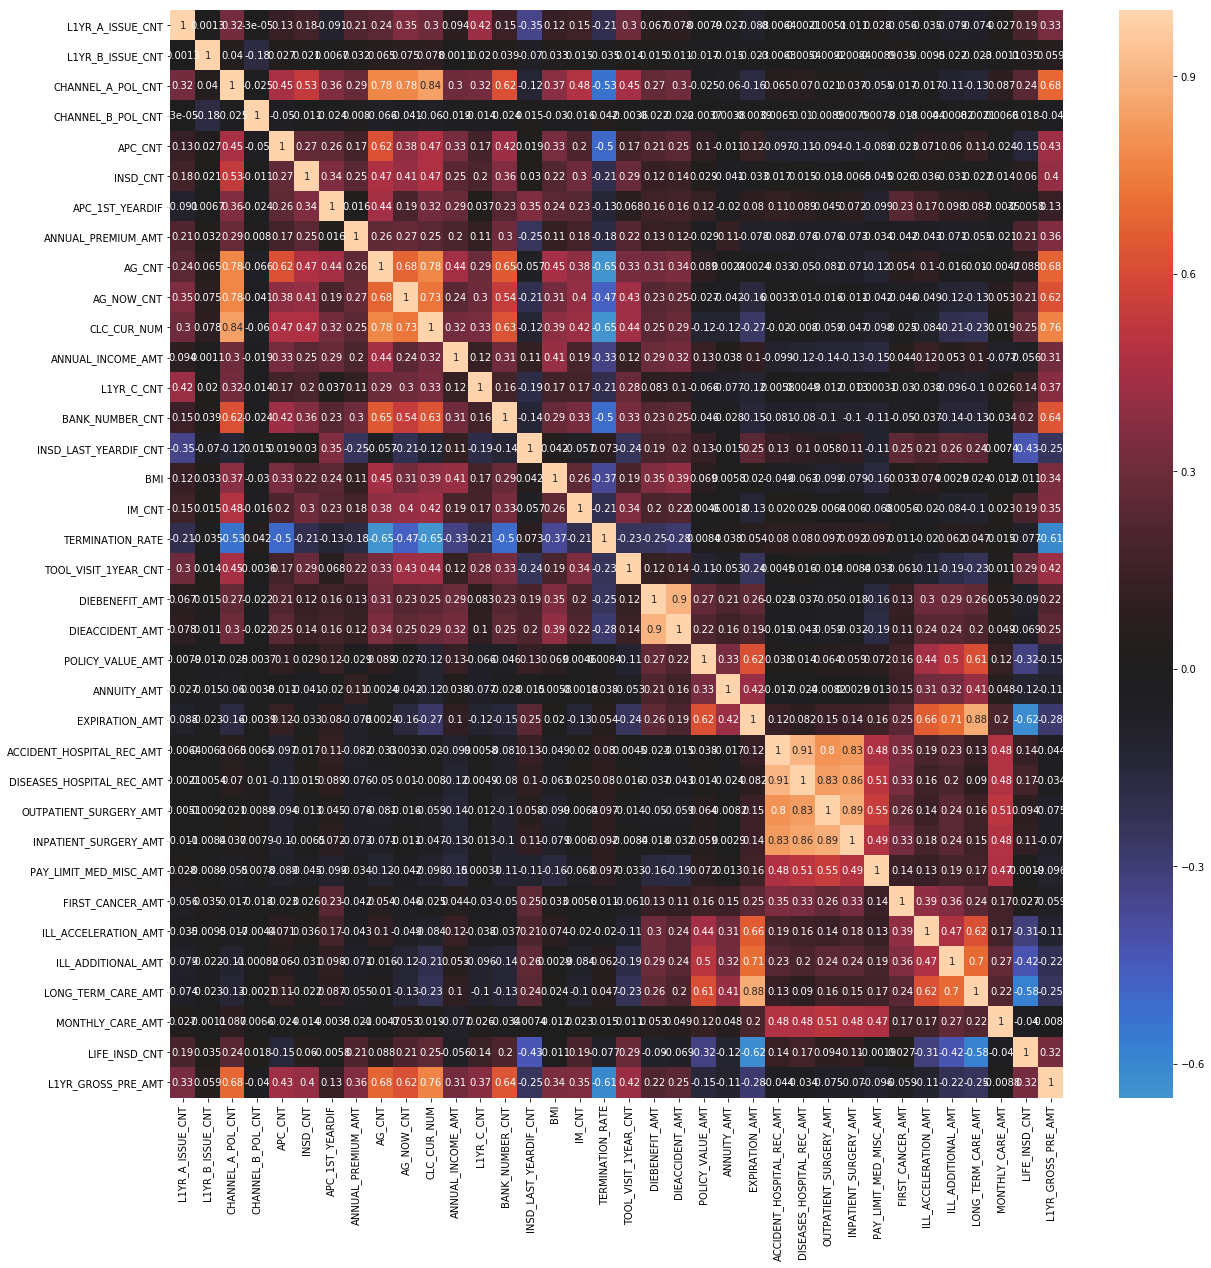

In [71]:
data_corr = data[data.columns[:36]].corr(method="spearman")
plt.figure(figsize=(20,20))
sns.heatmap(data_corr, center=0, annot=True)

## 變數重要性

In [92]:
data=pd.read_csv("train_test_boxcox_trans11_mean35.csv",encoding="big5")

In [56]:
from xgboost import XGBClassifier

cls = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.07, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [60]:
cls.fit(data[:100000],train_y)

C:\Users\a2279\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\a2279\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.07, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1, verbosity=1)

In [61]:
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, cls.get_booster().get_score(importance_type=importance_type))

weight:  {'LAST_A_ISSUE_DT': 40, 'OCCUPATION_CLASS_CD': 211, 'INSD_1ST_AGE': 204, 'X_H_IND_N': 30, 'AGE_高': 100, 'ANNUITY_AMT': 260, 'IF_ADD_R_IND_N': 19, 'ILL_ADDITIONAL_AMT': 112, 'APC_1ST_YEARDIF': 311, 'DIEACCIDENT_AMT': 37, 'IF_ADD_INSD_L_IND_Y': 32, 'INSD_LAST_YEARDIF_CNT': 222, 'L1YR_A_ISSUE_CNT': 80, 'TOOL_VISIT_1YEAR_CNT': 343, 'CHANNEL_A_POL_CNT': 183, 'AGE_中': 106, 'ANNUAL_PREMIUM_AMT': 397, 'ANNUAL_INCOME_AMT': 317, 'ILL_ACCELERATION_AMT': 140, 'IF_ISSUE_I_IND': 23, 'FINANCETOOLS_G_N': 11, 'BMI': 294, 'MARRIAGE_CD_1.0': 33, 'LONG_TERM_CARE_AMT': 99, 'IF_ISSUE_INSD_I_IND_Y': 35, 'B_IND_Y': 11, 'EDUCATION_CD_2.0': 18, 'EXPIRATION_AMT': 91, 'IF_ADD_INSD_R_IND_Y': 11, 'B_IND_N': 19, 'IF_ISSUE_J_IND': 54, 'IF_ISSUE_Q_IND': 28, 'CUST_9_SEGMENTS_CD_D': 22, 'EDUCATION_CD_3.0': 25, 'IF_S_REAL_IND_N': 25, 'EDUCATION_CD_1.0': 14, 'IF_ADD_INSD_G_IND_N': 5, 'LIFE_INSD_CNT': 83, 'CHARGE_CITY_CD_A1': 15, 'IF_ISSUE_INSD_J_IND_Y': 19, 'IM_IS_B_IND_N': 23, 'IM_IS_D_IND_N': 19, 'AG_CNT': 40, 

cover:  {'LAST_A_ISSUE_DT': 10744.049793198501, 'OCCUPATION_CLASS_CD': 2584.7308925100006, 'INSD_1ST_AGE': 2058.942961892549, 'X_H_IND_N': 7728.646184466666, 'AGE_高': 1294.4033419057, 'ANNUITY_AMT': 541.3399178555002, 'IF_ADD_R_IND_N': 38.27948467789473, 'ILL_ADDITIONAL_AMT': 594.6346600525001, 'APC_1ST_YEARDIF': 408.75443490221886, 'DIEACCIDENT_AMT': 714.4268741081082, 'IF_ADD_INSD_L_IND_Y': 94.3858875225, 'INSD_LAST_YEARDIF_CNT': 230.44930417459457, 'L1YR_A_ISSUE_CNT': 610.5361111914998, 'TOOL_VISIT_1YEAR_CNT': 966.65414358586, 'CHANNEL_A_POL_CNT': 838.1449787608194, 'AGE_中': 2870.5007757862268, 'ANNUAL_PREMIUM_AMT': 544.6716848792196, 'ANNUAL_INCOME_AMT': 268.25449393369075, 'ILL_ACCELERATION_AMT': 603.4831490958574, 'IF_ISSUE_I_IND': 1580.4080542286956, 'FINANCETOOLS_G_N': 10.438110292727272, 'BMI': 523.0713452274142, 'MARRIAGE_CD_1.0': 244.32985999484842, 'LONG_TERM_CARE_AMT': 546.0549493458586, 'IF_ISSUE_INSD_I_IND_Y': 1235.3561013865713, 'B_IND_Y': 228.53691352727273, 'EDUCATION

total_cover:  {'LAST_A_ISSUE_DT': 429761.99172794004, 'OCCUPATION_CLASS_CD': 545378.2183196101, 'INSD_1ST_AGE': 420024.36422608007, 'X_H_IND_N': 231859.385534, 'AGE_高': 129440.33419057, 'ANNUITY_AMT': 140748.37864243003, 'IF_ADD_R_IND_N': 727.3102088799999, 'ILL_ADDITIONAL_AMT': 66599.08192588, 'APC_1ST_YEARDIF': 127122.62925459007, 'DIEACCIDENT_AMT': 26433.794342000005, 'IF_ADD_INSD_L_IND_Y': 3020.34840072, 'INSD_LAST_YEARDIF_CNT': 51159.745526759994, 'L1YR_A_ISSUE_CNT': 48842.888895319986, 'TOOL_VISIT_1YEAR_CNT': 331562.37124994997, 'CHANNEL_A_POL_CNT': 153380.53111322995, 'AGE_中': 304273.08223334, 'ANNUAL_PREMIUM_AMT': 216234.65889705016, 'ANNUAL_INCOME_AMT': 85036.67457697997, 'ILL_ACCELERATION_AMT': 84487.64087342002, 'IF_ISSUE_I_IND': 36349.38524726, 'FINANCETOOLS_G_N': 114.81921322, 'BMI': 153782.97549685978, 'MARRIAGE_CD_1.0': 8062.885379829998, 'LONG_TERM_CARE_AMT': 54059.43998524, 'IF_ISSUE_INSD_I_IND_Y': 43237.463548529995, 'B_IND_Y': 2513.9060488, 'EDUCATION_CD_2.0': 1568.9

In [73]:
data.shape

(250000, 236)

In [67]:
importance=pd.DataFrame(sorted(cls.get_booster().get_score(importance_type='total_gain').items(),key=lambda item:item[1]))
importance.columns=["variable","importance_total_gain"]
importance

In [68]:
importance.columns=["variable","importance_total_gain"]
importance

,variable,importance_total_gain
0,IF_ISSUE_INSD_O_IND_N,1.889351
1,IF_ISSUE_INSD_L_IND_N,2.594559
2,LAST_B_ISSUE_DT,3.061295
3,FINANCETOOLS_F_Y,3.132092
4,X_A_IND_Y,4.274121
5,CHARGE_CITY_CD_C1,4.387087
6,X_F_IND_Y,5.512350
7,IF_ISSUE_K_IND,6.626033
8,IF_ISSUE_INSD_L_IND_Y,7.140154
9,CHARGE_CITY_CD_D,7.760622


In [69]:
importance.to_csv("importance_total_gain.csv",encoding="big5",index=False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

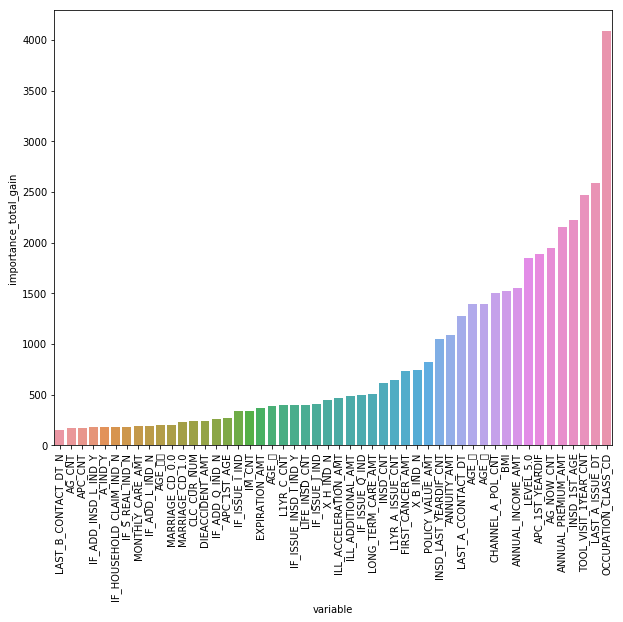

In [82]:
plt.figure(figsize=(10,8))
sns.barplot("variable","importance_total_gain",data=importance[150:200])
plt.xticks(rotation=90)

In [89]:
nvariable=[i for i in data.columns if i not in list(importance["variable"])] 

In [99]:
datanew=data.drop(nvariable,axis=1)

In [100]:
datanew.shape

(250000, 200)

In [97]:
importance_all=dict()
for i in range(len(data.columns)):
    importance_all[data.columns[i]]=cls.feature_importances_[i]

In [102]:
datanew.to_csv("train_test_boxcox_trans11_mean35_importance36.csv",encoding="big5",index=False)

In [103]:
datanew=datanew.drop(["IF_ISSUE_INSD_O_IND_N","IF_ISSUE_INSD_L_IND_N","LAST_B_ISSUE_DT","FINANCETOOLS_F_Y","X_A_IND_Y"],axis=1)

In [104]:
datanew.to_csv("train_test_boxcox_trans11_mean35_importance41.csv",encoding="big5",index=False)

In [107]:
datanew=pd.read_csv("train_test_boxcox_trans11_mean35_importance41.csv",encoding="big5")

In [108]:
datanew=datanew.drop(["CHARGE_CITY_CD_C1","X_F_IND_Y","IF_ISSUE_K_IND"],axis=1)

In [109]:
datanew.to_csv("train_test_boxcox_trans11_mean35_importance44.csv",encoding="big5",index=False)

In [110]:
datanew=datanew.drop(["IF_ISSUE_INSD_L_IND_Y"],axis=1)

In [111]:
datanew.to_csv("train_test_boxcox_trans11_mean35_importance45.csv",encoding="big5",index=False)

## 特徵有序化

In [116]:
train_test=pd.read_csv("train_test.csv",encoding="big5")

C:\Users\a2279\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (16,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [112]:
datanew=pd.read_csv("train_test_boxcox_trans11_mean35_importance44.csv",encoding="big5")

In [115]:
[i for i in datanew.columns]

['L1YR_A_ISSUE_CNT',
 'CHANNEL_A_POL_CNT',
 'CHANNEL_B_POL_CNT',
 'APC_CNT',
 'INSD_CNT',
 'APC_1ST_YEARDIF',
 'ANNUAL_PREMIUM_AMT',
 'AG_CNT',
 'AG_NOW_CNT',
 'CLC_CUR_NUM',
 'ANNUAL_INCOME_AMT',
 'L1YR_C_CNT',
 'BANK_NUMBER_CNT',
 'INSD_LAST_YEARDIF_CNT',
 'BMI',
 'IM_CNT',
 'TERMINATION_RATE',
 'TOOL_VISIT_1YEAR_CNT',
 'DIEBENEFIT_AMT',
 'DIEACCIDENT_AMT',
 'POLICY_VALUE_AMT',
 'ANNUITY_AMT',
 'EXPIRATION_AMT',
 'ACCIDENT_HOSPITAL_REC_AMT',
 'DISEASES_HOSPITAL_REC_AMT',
 'OUTPATIENT_SURGERY_AMT',
 'INPATIENT_SURGERY_AMT',
 'PAY_LIMIT_MED_MISC_AMT',
 'FIRST_CANCER_AMT',
 'ILL_ACCELERATION_AMT',
 'ILL_ADDITIONAL_AMT',
 'LONG_TERM_CARE_AMT',
 'MONTHLY_CARE_AMT',
 'LIFE_INSD_CNT',
 'L1YR_GROSS_PRE_AMT',
 'GENDER_F',
 'GENDER_M',
 'AGE_中',
 'AGE_中高',
 'AGE_低',
 'AGE_高',
 'CHARGE_CITY_CD_A1',
 'CHARGE_CITY_CD_A2',
 'CHARGE_CITY_CD_B1',
 'CHARGE_CITY_CD_B2',
 'CHARGE_CITY_CD_C2',
 'CHARGE_CITY_CD_D',
 'CHARGE_CITY_CD_E',
 'CONTACT_CITY_CD_A1',
 'CONTACT_CITY_CD_A2',
 'CONTACT_CITY_CD_B1',


In [121]:
train_test["RFM_R"].unique()

array(['低', '中高', '中', '高', nan], dtype=object)

In [122]:
train_test["REBUY_TIMES_CNT"].unique()

array(['低', '中', '中高', '高', nan], dtype=object)

In [123]:
train_test["LEVEL"].unique()

array([ 3.,  5.,  2.,  1.,  4., nan])

In [124]:
train_test["RFM_M_LEVEL"].unique()

array([ 3.,  5.,  7.,  8.,  9., 10., nan])

In [125]:
train_test["LIFE_CNT"].unique()

array(['中', '低', '高'], dtype=object)

In [128]:
np.sum(train_test["RFM_R"].isnull())

107521

In [129]:
np.sum(train_test["RFM_M_LEVEL"].isnull())

107496

In [130]:
np.sum(train_test["LEVEL"].isnull())

107521

In [131]:
datanew["AGE"]=train_test["AGE"].map({"低":1,"中":2,"中高":3,"高":4})
datanew["LIFE_CNT"]=train_test["LIFE_CNT"].map({"低":1,"中":2,"高":3})

In [133]:
datanew["RFM_M_LEVEL"]=train_test["RFM_M_LEVEL"].fillna(0)
datanew["LEVEL"]=train_test["LEVEL"].fillna(0)

In [135]:
datanew["REBUY_TIMES_CNT"]=train_test["REBUY_TIMES_CNT"].map({"低":1,"中":2,"中高":3,"高":4,np.nan:0})
datanew["RFM_R"]=train_test["RFM_R"].map({"低":1,"中":2,"中高":3,"高":4,np.nan:0})

In [142]:
datanew=datanew.drop(['AGE_中','AGE_中高','AGE_低','AGE_高','RFM_R_中','RFM_R_中高','RFM_R_低', 'REBUY_TIMES_CNT_中', 'REBUY_TIMES_CNT_中高', 'REBUY_TIMES_CNT_低','REBUY_TIMES_CNT_高','LEVEL_1.0','LEVEL_2.0','LEVEL_4.0','LEVEL_5.0','RFM_M_LEVEL_5.0','RFM_M_LEVEL_7.0', 'RFM_M_LEVEL_8.0', 'RFM_M_LEVEL_9.0','RFM_M_LEVEL_10.0','LIFE_CNT_中','LIFE_CNT_低','LIFE_CNT_高'],axis=1)

In [147]:
datanew=datanew.drop(["RFM_M_LEVEL_3.0"],axis=1)

In [148]:
datanew.to_csv("train_test_boxcox_trans11_mean35_importance44_order6.csv",encoding="big5",index=False)

In [145]:
nvariable

['L1YR_B_ISSUE_CNT',
 'IF_2ND_GEN_IND_Y',
 'RFM_R_高',
 'LEVEL_3.0',
 'IF_ADD_F_IND_Y',
 'IF_ADD_L_IND_Y',
 'IF_ADD_Q_IND_Y',
 'IF_ADD_G_IND_N',
 'IF_ADD_G_IND_Y',
 'IF_ADD_R_IND_Y',
 'IF_ADD_IND_Y',
 'L1YR_PAYMENT_REMINDER_IND_Y',
 'L1YR_LAPSE_IND_Y',
 'LAST_B_CONTACT_DT_Y',
 'C_IND_Y',
 'LAST_C_DT_Y',
 'IF_S_REAL_IND_Y',
 'IF_Y_REAL_IND_Y',
 'IM_IS_A_IND_Y',
 'IM_IS_B_IND_Y',
 'IM_IS_C_IND_Y',
 'IM_IS_D_IND_Y',
 'X_C_IND_Y',
 'X_F_IND_N',
 'IF_HOUSEHOLD_CLAIM_IND_Y',
 'IF_ISSUE_INSD_E_IND_N',
 'IF_ISSUE_INSD_E_IND_Y',
 'IF_ISSUE_INSD_H_IND_N',
 'IF_ISSUE_INSD_H_IND_Y',
 'IF_ISSUE_INSD_K_IND_Y',
 'IF_ISSUE_INSD_M_IND_N',
 'IF_ADD_INSD_G_IND_Y',
 'IF_ADD_INSD_IND_Y',
 'IF_ISSUE_E_IND',
 'IF_ISSUE_H_IND',
 'IF_ISSUE_M_IND']

## 特徵組合

In [314]:
train_test=pd.read_csv("train_test_boxcox_trans11_mean35_importance44_order6.csv",encoding="big5")

In [240]:
train_test_old=pd.read_csv("train_test.csv",encoding="big5")

In [241]:
train_test.shape

(250000, 174)

In [28]:
int_features = []
float_features = []
object_features = []

for dtype, feature in zip(train_test.dtypes,train_test.columns):
    if dtype == 'float64':
        float_features.append(feature)
    elif dtype == 'int64':
        int_features.append(feature)
    else:
        object_features.append(feature)
print(f'{len(int_features)} Integer Features : {int_features}\n')
print(f'{len(float_features)} Float Features : {float_features}\n')
print(f'{len(object_features)} Object Features : {object_features}')

4 Integer Features : ['AGE_x', 'LIFE_CNT', 'REBUY_TIMES_CNT', 'RFM_R']

174 Float Features : ['L1YR_A_ISSUE_CNT', 'CHANNEL_A_POL_CNT', 'CHANNEL_B_POL_CNT', 'APC_CNT', 'INSD_CNT', 'APC_1ST_YEARDIF', 'ANNUAL_PREMIUM_AMT', 'AG_CNT', 'AG_NOW_CNT', 'CLC_CUR_NUM', 'ANNUAL_INCOME_AMT', 'L1YR_C_CNT', 'BANK_NUMBER_CNT', 'INSD_LAST_YEARDIF_CNT', 'BMI', 'IM_CNT', 'TERMINATION_RATE', 'TOOL_VISIT_1YEAR_CNT_x_x', 'DIEBENEFIT_AMT', 'DIEACCIDENT_AMT', 'POLICY_VALUE_AMT', 'ANNUITY_AMT', 'EXPIRATION_AMT', 'ACCIDENT_HOSPITAL_REC_AMT', 'DISEASES_HOSPITAL_REC_AMT', 'OUTPATIENT_SURGERY_AMT', 'INPATIENT_SURGERY_AMT', 'PAY_LIMIT_MED_MISC_AMT', 'FIRST_CANCER_AMT', 'ILL_ACCELERATION_AMT', 'ILL_ADDITIONAL_AMT', 'LONG_TERM_CARE_AMT', 'MONTHLY_CARE_AMT', 'LIFE_INSD_CNT', 'L1YR_GROSS_PRE_AMT', 'GENDER_F', 'GENDER_M', 'CHARGE_CITY_CD_A1', 'CHARGE_CITY_CD_A2', 'CHARGE_CITY_CD_B1', 'CHARGE_CITY_CD_B2', 'CHARGE_CITY_CD_C2', 'CHARGE_CITY_CD_D', 'CHARGE_CITY_CD_E', 'CONTACT_CITY_CD_A1', 'CONTACT_CITY_CD_A2', 'CONTACT_CIT

In [6]:
from xgboost import XGBClassifier

cls = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.07, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [320]:
cls.fit(train_test[:100000],train_y)

C:\Users\a2279\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\a2279\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.07, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1, verbosity=1)

In [321]:
importance=pd.DataFrame(sorted(cls.get_booster().get_score(importance_type='total_gain').items(),key=lambda item:item[1]))
importance.columns=["variable","importance_total_gain"]
importance

,variable,importance_total_gain
0,IF_ISSUE_INSD_A_IND_Y,2.515320
1,CONTACT_CITY_CD_D,3.181916
2,LAST_A_CCONTACT_DT,3.601850
3,IF_ISSUE_INSD_O_IND_Y,4.276519
4,IF_ISSUE_INSD_B_IND_N,5.065476
5,IF_ISSUE_INSD_M_IND_Y,6.796375
6,FINANCETOOLS_E_Y,7.238314
7,IF_ADD_INSD_G_IND_N,8.299932
8,L1YR_GROSS_PRE_AMT,11.153753
9,IF_ISSUE_INSD_F_IND_N,11.786510


In [322]:
navaraible=[i for i in train_test.columns if i not in list(importance["variable"])]
navaraible

['X_B_IND_Y',
 'X_G_IND_Y',
 'X_H_IND_Y',
 'IF_ISSUE_INSD_K_IND_N',
 'IF_ISSUE_INSD_L_IND_Y',
 'FINANCETOOLS_E_N']

In [106]:
train_x["OCCUPATION_CLASS_CD"].unique()

array([ 1., nan,  2.,  3.,  5.,  4.,  6.,  0.])

In [149]:
train_test[:100000]["OCCUPATION_CLASS_CD"].unique()

array([0.01562416,        nan, 0.02727836, 0.02586883, 0.02654867,
       0.01975309, 0.03465347, 0.00459242])

In [44]:
train_test["LEVEL"].unique()

array([3., 5., 2., 1., 4., 0.])

In [45]:
train_test["AGE"].unique()

array([1, 3, 2, 4], dtype=int64)

In [315]:
train_test_old.shape

(250000, 130)

In [316]:
train_x=train_test_old[:100000]

In [151]:
train_x["y"]=train_y

C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [242]:
train_test["OCCUPATION_CLASS_CD"]=train_test["OCCUPATION_CLASS_CD"].fillna(0.07222222222222222)

In [243]:
train_test1=train_test[:100000]

In [244]:
train_test["OCCUPATION_CLASS_CD_LEVEL"]=train_test["OCCUPATION_CLASS_CD"]*train_test["LEVEL"]

In [245]:
train_test["OCCUPATION_CLASS_CD_AGE"]=train_test["OCCUPATION_CLASS_CD"]*train_test["AGE"]

In [265]:
train_x=train_test[:100000]

In [266]:
train_x["y"]=train_y

C:\Users\a2279\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [274]:
train_test["OCCUPATION_CLASS_CD_LAST_A_ISSUE_DT"]=pd.merge(train_test,train_x.pivot_table('y',index=["OCCUPATION_CLASS_CD","LAST_A_ISSUE_DT"]),on=["OCCUPATION_CLASS_CD","LAST_A_ISSUE_DT"],how="left")["y"]

In [233]:
def mergevariable(df,df1,variable1,variable2):
    df2=df.copy()
    df["{}_{}".format(variable1,variable2)]=pd.merge(df2,df1.groupby([variable1])[variable2].mean(),left_on=variable1,right_index=True)["{}_y".format(variable2)]
    return df

In [276]:
train_test=mergevariable(train_test,train_test1,"OCCUPATION_CLASS_CD","TOOL_VISIT_1YEAR_CNT")

In [ ]:
train_test=train_test.drop(['L1YR_GROSS_PRE_AMT','X_G_IND_Y','X_H_IND_Y','IF_ISSUE_INSD_B_IND_N','IF_ISSUE_INSD_F_IND_N','IF_ISSUE_INSD_G_IND_N','IF_ISSUE_INSD_K_IND_N','CUST_9_SEGMENTS_CD_E'],axis=1)

In [ ]:
train_test.to_csv("train_test_boxcox_trans11_mean35_importance44_order6_comd4.csv",encoding="big5",index=False)

In [ ]:
train_test=pd.read_csv("train_test_boxcox_trans11_mean35_importance44_order6_comd4.csv",encoding="big5")

In [296]:
train_test=mergevariable(train_test,train_test1,"INSD_1ST_AGE","ANNUAL_PREMIUM_AMT")
train_test=mergevariable(train_test,train_test1,"AGE","ANNUAL_PREMIUM_AMT")

In [277]:
train_test.shape

(250000, 178)

In [323]:
train_test=train_test.drop(['X_B_IND_Y',
 'X_G_IND_Y',
 'X_H_IND_Y',
 'IF_ISSUE_INSD_K_IND_N',
 'IF_ISSUE_INSD_L_IND_Y',
 'FINANCETOOLS_E_N'],axis=1)

In [ ]:
train_test.to_csv("train_test_boxcox_trans11_mean35_importance44_order6_comd6.csv",encoding="big5",index=False)